# **Modelo de machine learning para predicción de atraso de vuelo**

**COLABORADORES:**

*   BERENGUEL, Rafael

* CATANIA, Ezequiel

* FIORINO, Santiago

* GARCÍA, Nicolás Francisco

* IGLESIAS, Juan Martín

* LINIADO, Dylan

* ORTEGANO, Rafael

* PALACIOS, Martín

* PALMIERI, Marco

* ROSALES, Gustavo




## **1. Introducción**

En este notebook hemos desarrollado diferentes modelos de machine learning con el objetivo de predecir los retrasos en los vuelos que superen los 15 minutos, a partir del análisis de datos de vuelos del Aeropuerto Internacional de Santiago (SCEL) durante el año 2017.

## **2. Transformaciones iniciales y análisis de datos**

### 2.1. Limpiamos y transformamos datos iniciales

Importamos algunas bibliotecas necesarias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Cargamos los datos

In [ ]:
df = pd.read_csv("dataset_SCL.csv", dtype={"Vlo-I": "str", "Vlo-O": "str"})
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Sacamos las columnas:

    Ori-I, Ori-O, SIGLAORI, porque siempre es SCEL/Santiago
    
    AÑO, porque siempre es 2017

In [ ]:
df = df.drop(columns=["Ori-I", "Ori-O", "AÑO", "SIGLAORI"])
df.head()

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami


Vemos si hay datos faltantes

In [ ]:
df[df.isna().any(axis=1)]

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES
6068,2017-01-19 11:00:00,200,SPJC,LAW,2017-01-19 11:03:00,NaN,SPJC,56R,19,1,Jueves,I,Latin American Wings,Lima


Solo hay un valor NaN en Vlo-O, lo rellenamos con su Vlo-I

In [ ]:
df['Vlo-O'].fillna(df['Vlo-I'], inplace=True)

Detectamos y eliminamos las filas en las que no coincidia el numero de vuelo programado con el operado

In [ ]:
df['Vlo-O_coerce'] = df['Vlo-O'].apply(lambda x: 1 if pd.to_numeric(x,errors='coerce') > 0 else 0)
df['Vlo-I_coerce'] = df['Vlo-I'].apply(lambda x: 1 if pd.to_numeric(x,errors='coerce') > 0 else 0)
df['coerce'] = df['Vlo-O_coerce'] + df['Vlo-I_coerce']
df.drop(df[(df.coerce < 2)].index, axis=0, inplace=True)
df.drop(columns=['Vlo-O_coerce','Vlo-I_coerce','coerce'], axis=1, inplace=True)

Convertimos Fechas a tipo datetime

In [ ]:
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])

Convertimos TIPOVUELO (I/N) a bool: True si es Internacional, False si es Nacional

In [ ]:
df["TIPOVUELO"] = df["TIPOVUELO"] == "I"

### 2.2. Creamos nuestra variable target

Nuestro criterio para decidir si el vuelo se atrasó será que despegó más de 15 minutos más tarde de la hora programada

Diferencia en minutos entre la hora programada y la hora real

In [ ]:
df["dif_min"] = (df["Fecha-O"] - df["Fecha-I"]).dt.total_seconds() / 60

True si el vuelo atrasó más de 15 minutos

In [ ]:
df["atraso_15"] = df["dif_min"] > 15 

### 2.3. Creamos las variables solicitadas

Agregamos periodo del día

In [ ]:
df["periodo_dia"] = np.where(df["Fecha-I"].dt.hour.between(5, 11), "mañana", np.where(df["Fecha-I"].dt.hour.between(12, 18), "tarde", "noche"))

Agregamos temporada alta

In [ ]:
condiciones = [
    (((df["Fecha-I"].dt.month == 12) & (df["Fecha-I"].dt.day >= 15)) |
    ((df["Fecha-I"].dt.month == 1) | (df["Fecha-I"].dt.month == 2)) |
    ((df["Fecha-I"].dt.month == 3) & (df["Fecha-I"].dt.day <= 3))),
    ((df["Fecha-I"].dt.month == 7) & (df["Fecha-I"].dt.day >= 15)),
    ((df["Fecha-I"].dt.month == 9) & (df["Fecha-I"].dt.day >= 11)),
]
df["temporada_alta"] = np.select(condiciones, [True, True, True], default=False)

Exportamos las variables adicionales en un archivo synthetic_features.csv

In [ ]:
df[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv('synthetic_features.csv')

Agregamos hora

In [ ]:
df["hora"] = df["Fecha-I"].dt.hour

### 2.4. Análisis de los vuelos

### Diferencia de minutos

In [ ]:
df["dif_min"].describe()

count    68186.000000
mean         9.105051
std         19.303412
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64

Notamos que en la diferencia de minutos hay valores negativos, hasta -14. Esto indicaría que el avión salió 14 minutos antes de lo esperado. Podría ser un error o podría ser que si todos los pasajeros ya están a bordo, el avión salga antes.

### Cantidad de atrasos de más de 15 minutos

In [ ]:
count = df["atraso_15"].value_counts()
print(f"Hay {count[1]} vuelos con atraso de más de 15 minutos, y {count[0]} sin atraso.")
print(f"El {round(count[1] / (count[0] + count[1]) * 100, 2)}% de los vuelos están atrasados.")

Hay 12604 vuelos con atraso de más de 15 minutos, y 55582 sin atraso.
El 18.48% de los vuelos están atrasados.


### Cantidad de vuelos por periodo del día

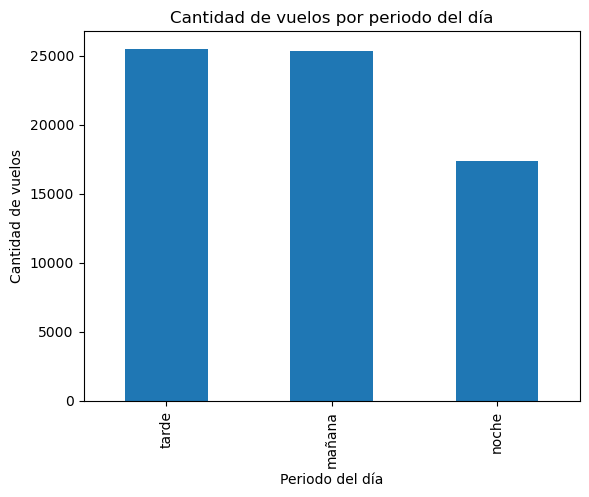

In [ ]:
df["periodo_dia"].value_counts().plot(kind="bar")
plt.title("Cantidad de vuelos por periodo del día")
plt.xlabel("Periodo del día")
plt.ylabel("Cantidad de vuelos")
plt.show()

### Cantidad de vuelos por día de la semana

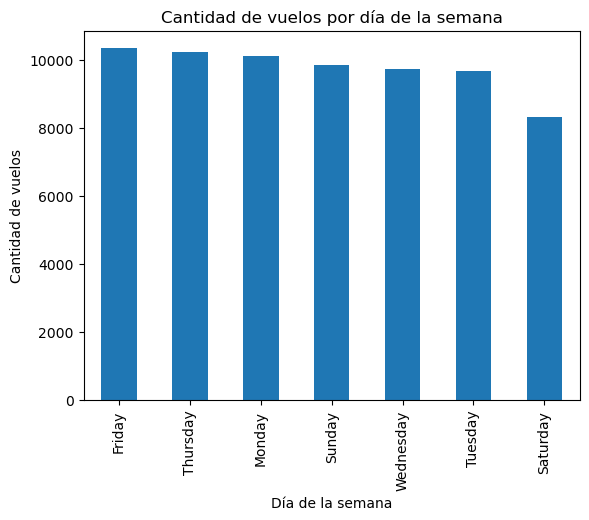

In [ ]:
df["Fecha-I"].dt.day_name().value_counts().plot(kind="bar")
plt.title("Cantidad de vuelos por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Cantidad de vuelos")
plt.show()

### Cantidad de vuelos por mes

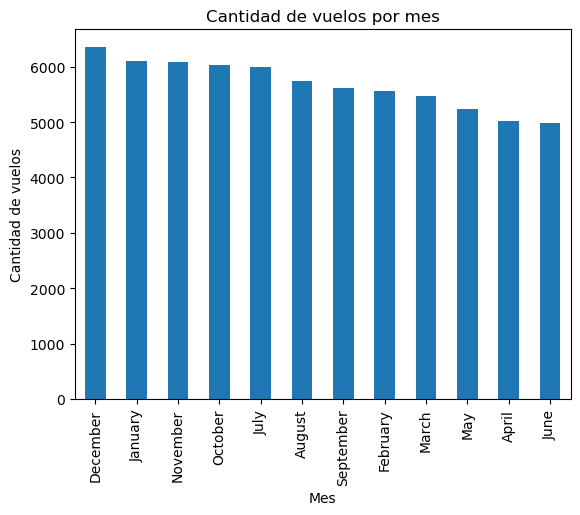

In [ ]:
df["Fecha-I"].dt.month_name().value_counts().plot(kind="bar")
plt.title("Cantidad de vuelos por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad de vuelos")
plt.show()

Tanto por periodo del día, día de la semana, y mes, hay una buena cantidad de datos de vuelos. Está relativamente balanceado.

### Tasa de atrasos de más de 15 minutos por Des-I

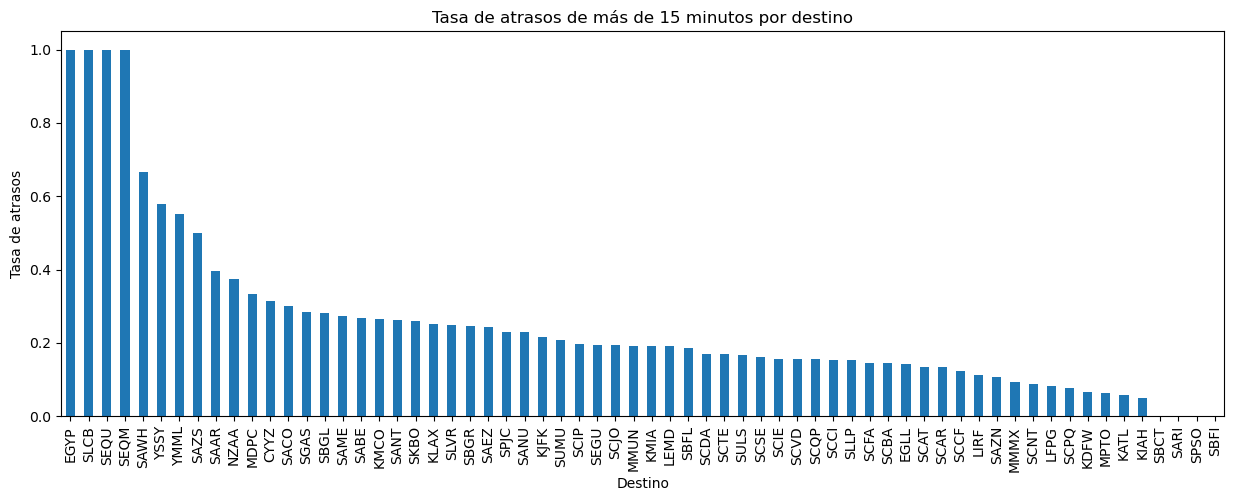

In [ ]:
df.groupby("Des-I")["atraso_15"].mean().sort_values(ascending=False).plot(kind="bar", figsize=(15, 5))
plt.title("Tasa de atrasos de más de 15 minutos por destino")
plt.xlabel("Destino")
plt.ylabel("Tasa de atrasos")
plt.show()

In [ ]:
print("Cant. de vuelos a los destinos que tienen 100% de atraso:")
print(len(df[df["Des-I"] == "EGYP"]), len(df[df["Des-I"] == "SLCB"]), len(df[df["Des-I"] == "SEQU"]), len(df[df["Des-I"] == "SEQM"]))
print("Cant. de vuelos a los destinos que tienen 0% de atraso:")
print(len(df[df["Des-I"] == "SBCT"]), len(df[df["Des-I"] == "SARI"]), len(df[df["Des-I"] == "SPSO"]), len(df[df["Des-I"] == "SBFI"]))

Cant. de vuelos a los destinos que tienen 100% de atraso:
1 1 1 1
Cant. de vuelos a los destinos que tienen 0% de atraso:
3 1 1 1


En el gráfico se ve que hay ciertos destinos con 100% de atraso, y otros con 0%, lo cual es raro. Cuando contamos la cantidad de vuelos a esos destinos vimos que tenían uno solo, lo cual explica esos valores ya que si ese único vuelo se atrasó, queda 100%, y si no se retrasó queda 0%.

### Tasa de atrasos de más de 15 minutos por empresa

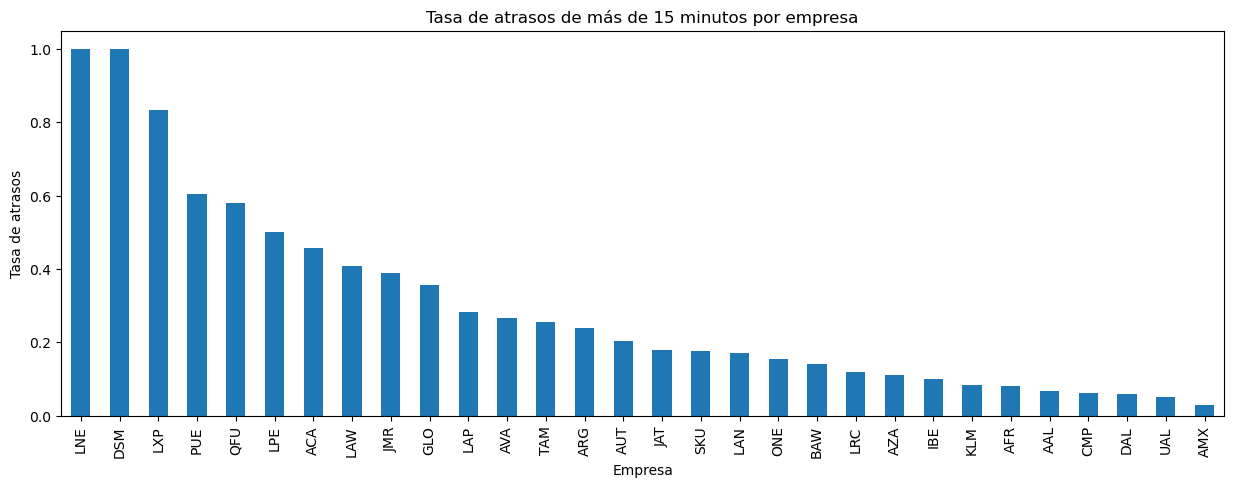

In [ ]:
df.groupby("Emp-I")["atraso_15"].mean().sort_values(ascending=False).plot(kind="bar", figsize=(15, 5))
plt.title("Tasa de atrasos de más de 15 minutos por empresa")
plt.xlabel("Empresa")
plt.ylabel("Tasa de atrasos")
plt.show()

In [ ]:
print("Cant. de vuelos de empresas con 100% de atraso:")
print(len(df[df["Emp-I"] == "LNE"]), len(df[df["Emp-I"] == "DSM"]))

Cant. de vuelos de empresas con 100% de atraso:
1 2


Pasa lo mismo con las empresas. Las de 100% de atraso es porque tienen 1 solo vuelo registrado, y se atrasó.

### Tasa de atrasos de más de 15 minutos por mes

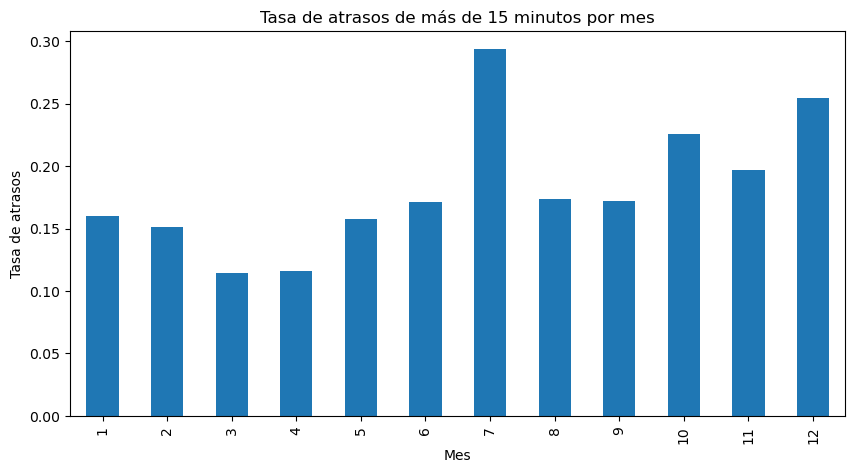

In [ ]:
df.groupby("MES")["atraso_15"].mean().plot(kind="bar", figsize=(10, 5))
plt.title("Tasa de atrasos de más de 15 minutos por mes")
plt.xlabel("Mes")
plt.ylabel("Tasa de atrasos")
plt.show()

Vemos una diferencia significativa en la tasa de atrasos por mes. En Julio se atrasan casi el 30% de los vuelos, mientras que en marzo el 12%. Creemos que será un feature importante a la hora de predecir el atraso de los vuelos.

### Tasa de atrasos de más de 15 minutos por hora

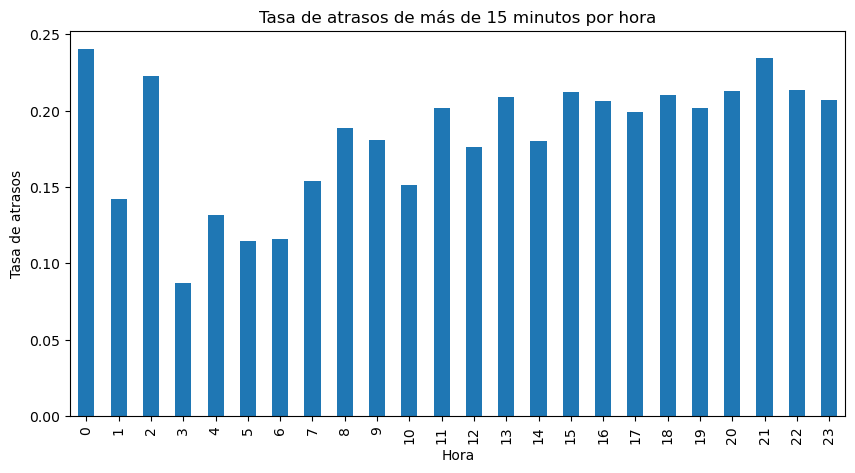

In [ ]:
df.groupby("hora")["atraso_15"].mean().plot(kind="bar", figsize=(10, 5))
plt.title("Tasa de atrasos de más de 15 minutos por hora")
plt.xlabel("Hora")
plt.ylabel("Tasa de atrasos")
plt.show()

Con la hora también se ve una influencia en la tasa de atrasos.

### Tasa de atrasos por tipo de temporada

In [ ]:
tasa_temporada = df.groupby("temporada_alta")["atraso_15"].mean()
print("La tasa de atrasos en temporada alta es de", round(tasa_temporada[1] * 100, 2), "%")
print("La tasa de atrasos en temporada baja es de", round(tasa_temporada[0] * 100, 2), "%")

La tasa de atrasos en temporada alta es de 19.64 %
La tasa de atrasos en temporada baja es de 17.91 %


Como era de esperar, en temporada alta hay más atrasos.

### Tasa de atrasos por tipo de vuelo

In [ ]:
tasa_vuelo = df.groupby("TIPOVUELO")["atraso_15"].mean()
print("La tasa de atrasos en vuelos internacionales es de", round(tasa_vuelo[1] * 100, 2), "%")
print("La tasa de atrasos en vuelos nacionales es de", round(tasa_vuelo[0] * 100, 2), "%")

La tasa de atrasos en vuelos internacionales es de 22.56 %
La tasa de atrasos en vuelos nacionales es de 15.04 %


Otra cosa esperable, los vuelos internacionales son mas propensos a atrasarse.

## **3. Extensión de datos**

### 3.1 Variables agregadas

#### sum_atraso_15

Es la sumatoria de vuelos con retrasos que hubieron en los últimos 15 días anteriores a cada fecha del dataset, por lo que si hay una gran cantidad de atrasos los días anteriores, es más probable que el próximo vuelo se retrase.

In [ ]:
df['sum_atraso_15'] = df.sort_values('Fecha-I')['atraso_15'].rolling(window=15).sum().shift()
df['sum_atraso_15'].fillna(0, inplace=True)

#### dif_min_atraso

Es la cantidad de minutos transcurridos desde el último atraso ocurrido. Esta variable nos otorga información de corto plazo, que puede influir en mayor medida en la predicción del atraso siguiente.

In [ ]:
df = df.sort_values('Fecha-I')

mask = df['atraso_15'] == 1

df['last_atraso'] = df.loc[mask, 'Fecha-I']
df['last_atraso'] = df['last_atraso'].fillna(method='ffill')

diff_min = (df['Fecha-I'] - df['last_atraso']).dt.total_seconds() / 60

df['dif_min_atraso'] = diff_min.shift()
df['dif_min_atraso'] = df['dif_min_atraso'].fillna(0)

df = df.drop('last_atraso', axis=1)

#### promedio_min_atraso_anteriores

Es el promedio móvil de minutos transcurridos entre los últimos 10 vuelos anteriores, que puede proporcionar la probabilidad de que se produzca un retraso.

In [ ]:
df = df.sort_values('Fecha-I')

df['promedio_min_atraso_anteriores'] = df[df['atraso_15']==1]['dif_min_atraso'].rolling(window=10).mean()
df['promedio_min_atraso_anteriores'] = df[df['atraso_15']==1]['promedio_min_atraso_anteriores'].fillna(0)
df['promedio_min_atraso_anteriores'] = df['promedio_min_atraso_anteriores'].fillna(method="ffill")
df['promedio_min_atraso_anteriores'] = df['promedio_min_atraso_anteriores'].fillna(0)

### 3.2. Datos externos

#### Distancia

Agregamos las distancias a todos los aeropuertos destino

In [ ]:
df_dist = pd.read_csv('distancias.csv')
df = pd.merge(df, df_dist, on='Des-O', how='left')
df[["Des-I", "distancia"]].sample(5)

,Des-I,distancia
7637,SCCI,2181
57988,SCAT,681
25256,SCTE,917
33424,SCAT,681
45008,SBGR,2616


#### Clima

Primera fuente: climatologia.meteochile.gob.cl/

De acá sacamos la humedad, presión, temperatura, dirección del viento, velocidad del viento, RRR6 y Traza (datos de lluvia)

In [ ]:
clima = pd.read_csv('clima.csv')
clima["datetime"] = pd.to_datetime(clima["datetime"])
clima.head()

,datetime,humedad,presion,temperatura,viento_dd,viento_ff,viento_vrb,RRR6_Valor,Traza_Valor,RRR6_interpolated,Traza_interpolated
0,2017-01-01 00:00:00,56.0,960.3,20.6,210.0,13.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 01:00:00,58.0,961.0,19.9,200.0,7.0,0.0,NaN,NaN,0.0,0.0
2,2017-01-01 02:00:00,65.0,961.3,18.0,150.0,9.0,0.0,NaN,NaN,0.0,0.0
3,2017-01-01 03:00:00,64.0,961.0,18.2,160.0,7.0,0.0,NaN,NaN,0.0,0.0
4,2017-01-01 04:00:00,69.0,961.6,16.8,160.0,7.0,0.0,NaN,NaN,0.0,0.0


In [ ]:
clima.isnull().sum()

datetime                 0
humedad                  0
presion                  0
temperatura              0
viento_dd             2046
viento_ff                0
viento_vrb               0
RRR6_Valor            7298
Traza_Valor           7298
RRR6_interpolated        0
Traza_interpolated       0
dtype: int64

Hay varios valores nulos en la dirección del viento, los vamos a rellenar con el valor anterior (la dirección del viento una hora atrás).

In [ ]:
clima["viento_dd"] = clima["viento_dd"].fillna(method="ffill")
df = pd.merge_asof(df.sort_values('Fecha-I'), clima.sort_values('datetime'), left_on="Fecha-I", right_on="datetime", direction="nearest")
df[["Vlo-I", "Emp-I", "humedad", "presion", "temperatura"]].sample(5)

,Vlo-I,Emp-I,humedad,presion,temperatura
45309,156,LAN,91.0,966.8,5.4
11219,632,LAN,51.0,959.9,23.8
20518,802,SKU,91.0,964.1,15.5
38370,276,CMP,35.0,959.1,23.6
18680,144,LAN,71.0,959.1,11.1


## **4. Preparación de datos para los modelos**

Probamos distintos modelos para clasificar entre 2 categorías: Atrasado o no, siendo "atrasado" lo que indica la variable "atraso_15", es decir, un atraso de más de 15 minutos.

### 4.1. Elección de variables

Elegimos los datos que se van a usar en el modelo:

In [ ]:
df_model = df[["Vlo-I","Fecha-I", "Des-I", "DIANOM", "Emp-I", "MES", "Des-O", "Emp-O", "OPERA", "TIPOVUELO", "periodo_dia", "temporada_alta", "distancia", "hora", "atraso_15", "humedad", "presion", "temperatura", "viento_ff", "viento_dd", "RRR6_interpolated", "Traza_interpolated", "sum_atraso_15", 'promedio_min_atraso_anteriores', 'dif_min_atraso']].copy()
df_model.head()

,Vlo-I,Fecha-I,Des-I,DIANOM,Emp-I,MES,Des-O,Emp-O,OPERA,TIPOVUELO,...,humedad,presion,temperatura,viento_ff,viento_dd,RRR6_interpolated,Traza_interpolated,sum_atraso_15,promedio_min_atraso_anteriores,dif_min_atraso
0,11,2017-01-01 00:15:00,MMMX,Domingo,AMX,1,MMMX,AMX,Aeromexico,True,...,56.0,960.3,20.6,13.0,210.0,0.0,0.0,0.0,0.0,0.0
1,572,2017-01-01 01:15:00,SKBO,Domingo,LAN,1,SKBO,LAN,Grupo LATAM,True,...,58.0,961.0,19.9,7.0,200.0,0.0,0.0,0.0,0.0,0.0
2,495,2017-01-01 01:23:00,MPTO,Domingo,CMP,1,MPTO,CMP,Copa Air,True,...,58.0,961.0,19.9,7.0,200.0,0.0,0.0,0.0,0.0,0.0
3,240,2017-01-01 01:33:00,SKBO,Domingo,AVA,1,SKBO,AVA,Avianca,True,...,65.0,961.3,18.0,9.0,150.0,0.0,0.0,0.0,0.0,0.0
4,276,2017-01-01 01:42:00,MPTO,Domingo,CMP,1,MPTO,CMP,Copa Air,True,...,65.0,961.3,18.0,9.0,150.0,0.0,0.0,0.0,0.0,0.0


Pasamos las variables categóricas a numéricas con un promedio movil de cuantos vuelos que presenten la misma categoría anteriores presentaron atrasos

In [ ]:
# Para cada fila, reemplaza el valor de la columna "column" por el
# promedio de atrasos de los últimos n vuelos de la misma categoría
def replace_by_last_n_flights_ewm(in_df, column, n_days):
    dataframes = []
    for i in in_df[column].unique():
        dataframes.append(in_df[in_df[column] == i].sort_values("Fecha-I"))
    for dataframe in dataframes:
        dataframe[column] = dataframe["atraso_15"].shift(1).ewm(span=n_days,adjust=True).mean()
    out_df = pd.concat(dataframes)
    out_df[column] = out_df[column].fillna(0)
    return out_df

In [ ]:
categorical = ["Vlo-I","Des-O", "DIANOM", "Emp-O", "OPERA", "Des-I", "Emp-I", "periodo_dia"]
for category in categorical:
    df_model = replace_by_last_n_flights_ewm(df_model, category, 150)
df_model = df_model.drop("Fecha-I", axis=1)
df_model.head()

,Vlo-I,Des-I,DIANOM,Emp-I,MES,Des-O,Emp-O,OPERA,TIPOVUELO,periodo_dia,...,humedad,presion,temperatura,viento_ff,viento_dd,RRR6_interpolated,Traza_interpolated,sum_atraso_15,promedio_min_atraso_anteriores,dif_min_atraso
0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,True,0.0,...,56.0,960.3,20.6,13.0,210.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,True,0.0,...,58.0,961.0,19.9,7.0,200.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,True,0.0,...,58.0,961.0,19.9,7.0,200.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,True,0.0,...,65.0,961.3,18.0,9.0,150.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,True,0.0,...,65.0,961.3,18.0,9.0,150.0,0.0,0.0,0.0,0.0,0.0


También se probó LabelEncoding y OneHotEncoding+PCA, ambos dando peor resultado que el método propuesto

Separamos los datos en los de entrenamiento y los de testeo:

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_model, test_size=0.2, random_state=3)
print("Cantidad de datos de entrenamiento:", len(df_train))
print("Cantidad de datos de testeo:", len(df_test))

Cantidad de datos de entrenamiento: 54548
Cantidad de datos de testeo: 13638


### 4.2. Normalizamos

También hay varias opciones, pero la que mejor funcionó fue MinMax

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
df_train.head()

,Vlo-I,Des-I,DIANOM,Emp-I,MES,Des-O,Emp-O,OPERA,TIPOVUELO,periodo_dia,...,humedad,presion,temperatura,viento_ff,viento_dd,RRR6_interpolated,Traza_interpolated,sum_atraso_15,promedio_min_atraso_anteriores,dif_min_atraso
0,0.409207,0.268808,0.145833,0.242933,1.000000,0.268808,0.242486,0.242570,1.0,0.252860,...,0.119565,0.134259,0.861042,0.545455,0.611111,0.0,0.0,0.200000,0.191858,0.016216
1,0.336961,0.340807,0.323913,0.298538,1.000000,0.339070,0.295912,0.295204,1.0,0.377440,...,0.619565,0.189815,0.471464,0.090909,0.444444,0.0,0.0,0.266667,0.074300,0.000000
2,0.716886,0.384125,0.226993,0.426729,0.545455,0.384263,0.426729,0.426729,1.0,0.414620,...,0.858696,0.597222,0.305211,0.136364,0.972222,0.0,0.0,0.066667,0.139949,0.059459
3,0.272814,0.178597,0.500075,0.367082,1.000000,0.178597,0.260211,0.390294,0.0,0.784182,...,0.173913,0.212963,0.841191,0.590909,0.583333,0.0,0.0,0.600000,0.015776,0.009730
4,0.078674,0.197395,0.188130,0.052306,0.909091,0.197396,0.052306,0.052306,1.0,0.327481,...,0.304348,0.333333,0.679901,0.590909,0.500000,0.0,0.0,0.333333,0.103817,0.000000


In [ ]:
X_train = df_train.drop("atraso_15", axis=1)
y_train = df_train["atraso_15"]

X_test = df_test.drop("atraso_15", axis=1)
y_test = df_test["atraso_15"]

In [ ]:
df_train["atraso_15"].value_counts()

0.0    44423
1.0    10125
Name: atraso_15, dtype: int64

Hay muchos más vuelos sin atraso que con atraso. Balancear podría dar mejores resultados.

### 4.3. Balanceo del dataset

#### Opcion 1: Oversampling

##### SMOTE (Synthetic Minority Oversampling Technique)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, sampling_strategy=0.4)
X_train_smote, y_train_smote = sm.fit_resample(df_train.drop("atraso_15", axis=1), df_train["atraso_15"])
y_train_smote.value_counts()

0.0    44423
1.0    17769
Name: atraso_15, dtype: int64

#### Opción 2: Undersampling

##### Random Undersampling

In [ ]:
# Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_train_rus, y_train_rus = rus.fit_resample(df_train.drop("atraso_15", axis=1), df_train["atraso_15"])
y_train_rus.value_counts()

0.0    20250
1.0    10125
Name: atraso_15, dtype: int64

##### Edited Nearest Neighbours

In [ ]:
# ENN undersampling
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours()
X_train_enn, y_train_enn = enn.fit_resample(df_train.drop("atraso_15", axis=1), df_train["atraso_15"])
y_train_enn.value_counts()

0.0    29190
1.0    10125
Name: atraso_15, dtype: int64

##### Neighbourhood Cleaning Rule

In [ ]:
# NCR undersampling
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule()
X_train_ncr, y_train_ncr = ncr.fit_resample(df_train.drop("atraso_15", axis=1), df_train["atraso_15"])
y_train_ncr.value_counts()

0.0    28787
1.0    10125
Name: atraso_15, dtype: int64

##### SMOTE + RUS

In [ ]:
# SMOTE + RUS
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_train_smote_rus, y_train_smote_rus = rus.fit_resample(X_train_smote, y_train_smote)
y_train_smote_rus.value_counts()

0.0    35538
1.0    17769
Name: atraso_15, dtype: int64

## **5. Modelos**

Como la mayoría de modelos tienen los métodos predict y predict proba, hacemos una función con la cual evaluar las métricas que se puede usar en todos.

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.9, linecolor='white')
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, f1_score
def train_and_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print("Métricas con el set de test")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
    print("Accuracy:", model.score(X_test, y_test))
    
    print("\n\nConfusion matrix for the test predictions")
    plot_confusion_matrix(y_test, y_pred)
    
    y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    print("\n\nMétricas con el set de train")
    print(classification_report(y_train, y_pred))
    print("ROC AUC:", roc_auc_score(y_train, y_pred_proba))
    print("Accuracy:", model.score(X_train, y_train))

### Modelo 1: Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=6)

Métricas sin balanceo:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90     11159
         1.0       0.56      0.14      0.22      2479

    accuracy                           0.82     13638
   macro avg       0.70      0.56      0.56     13638
weighted avg       0.79      0.82      0.78     13638

ROC AUC: 0.7304777461982742
Accuracy: 0.823654494793958


Confusion matrix for the test predictions


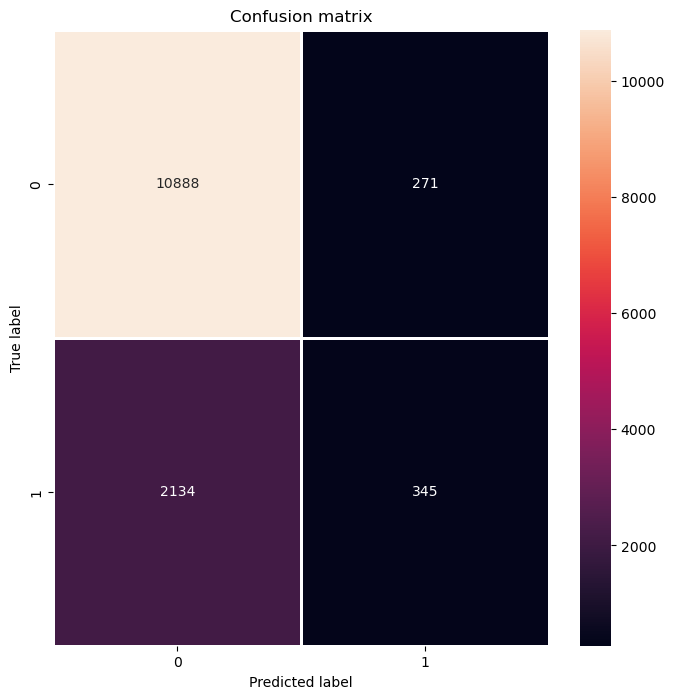



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90     44423
         1.0       0.64      0.15      0.25     10125

    accuracy                           0.83     54548
   macro avg       0.74      0.57      0.57     54548
weighted avg       0.80      0.83      0.78     54548

ROC AUC: 0.7354879851750692
Accuracy: 0.8268130820561708


In [ ]:
# Sin balanceo
print("Métricas sin balanceo:")
train_and_test(dt, X_train, y_train, X_test, y_test)

Lo probamos con cada técnica de over/under sampling:

Métricas SMOTE:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.89     11159
         1.0       0.46      0.29      0.36      2479

    accuracy                           0.81     13638
   macro avg       0.66      0.61      0.62     13638
weighted avg       0.78      0.81      0.79     13638

ROC AUC: 0.7155791415160401
Accuracy: 0.8087696143129491


Confusion matrix for the test predictions


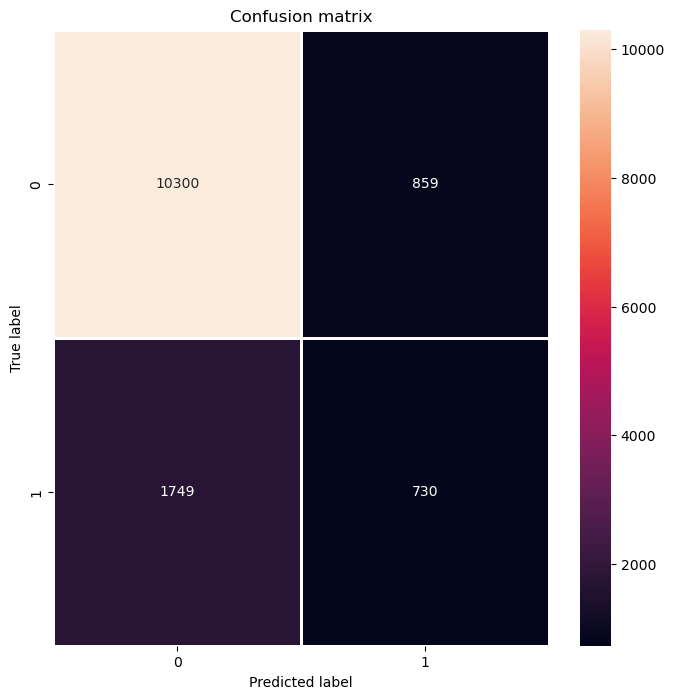



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.86     44423
         1.0       0.69      0.40      0.50     17769

    accuracy                           0.78     62192
   macro avg       0.74      0.66      0.68     62192
weighted avg       0.76      0.78      0.75     62192

ROC AUC: 0.7688906733984037
Accuracy: 0.7760322871108825


In [ ]:
print("Métricas SMOTE:")
train_and_test(dt, X_train_smote, y_train_smote, X_test, y_test)

Métricas RUS:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87     11159
         1.0       0.41      0.37      0.39      2479

    accuracy                           0.79     13638
   macro avg       0.64      0.63      0.63     13638
weighted avg       0.78      0.79      0.79     13638

ROC AUC: 0.7262651582008288
Accuracy: 0.7900718580437014


Confusion matrix for the test predictions


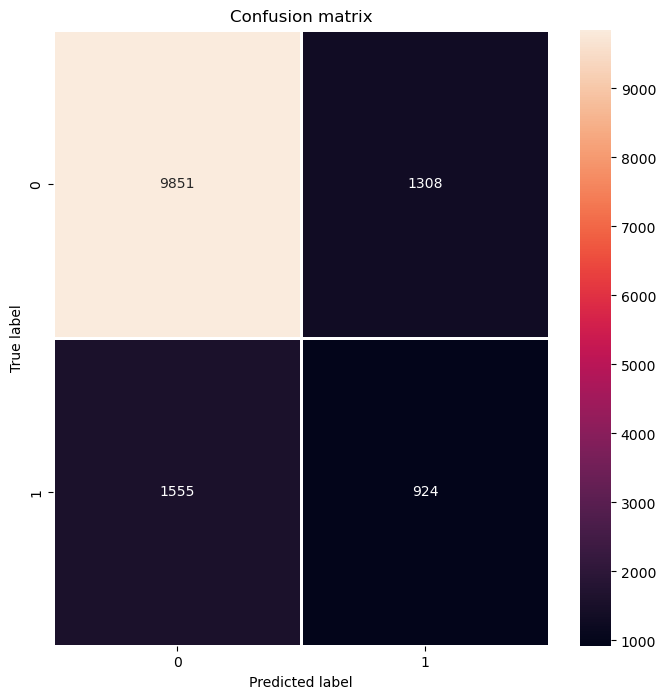



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81     20250
         1.0       0.64      0.38      0.48     10125

    accuracy                           0.72     30375
   macro avg       0.69      0.64      0.65     30375
weighted avg       0.71      0.72      0.70     30375

ROC AUC: 0.7339496686480718
Accuracy: 0.7228641975308642


In [ ]:
print("Métricas RUS:")
train_and_test(dt, X_train_rus, y_train_rus, X_test, y_test)

Métricas ENN:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     11159
         1.0       0.43      0.40      0.42      2479

    accuracy                           0.79     13638
   macro avg       0.65      0.64      0.65     13638
weighted avg       0.79      0.79      0.79     13638

ROC AUC: 0.7271759181823075
Accuracy: 0.7948379527789998


Confusion matrix for the test predictions


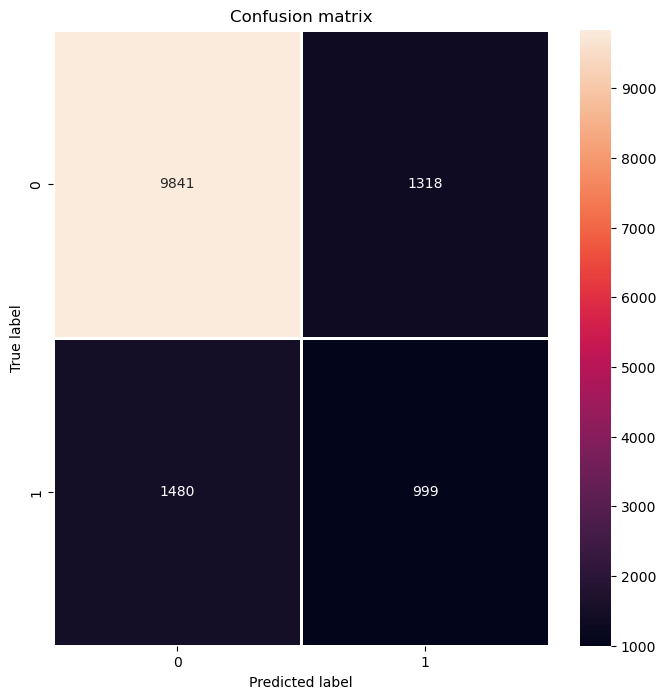



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88     29190
         1.0       0.75      0.40      0.52     10125

    accuracy                           0.81     39315
   macro avg       0.78      0.68      0.70     39315
weighted avg       0.80      0.81      0.79     39315

ROC AUC: 0.7959330837975123
Accuracy: 0.8112425282970877


In [ ]:
print("Métricas ENN:")
train_and_test(dt, X_train_enn, y_train_enn, X_test, y_test)

Métricas NCR:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87     11159
         1.0       0.41      0.39      0.40      2479

    accuracy                           0.79     13638
   macro avg       0.64      0.64      0.64     13638
weighted avg       0.78      0.79      0.79     13638

ROC AUC: 0.7269623851012543
Accuracy: 0.788165420149582


Confusion matrix for the test predictions


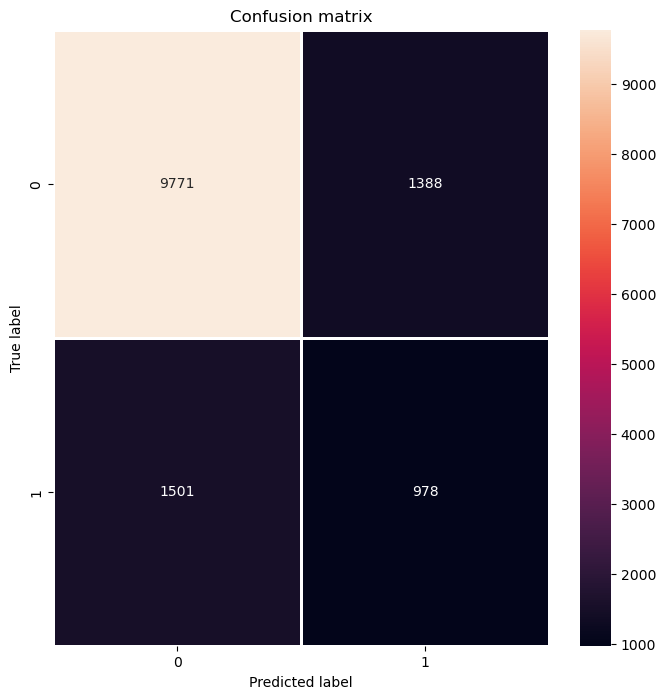



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88     28787
         1.0       0.72      0.41      0.52     10125

    accuracy                           0.80     38912
   macro avg       0.77      0.67      0.70     38912
weighted avg       0.79      0.80      0.78     38912

ROC AUC: 0.7930792491638243
Accuracy: 0.8032483552631579


In [ ]:
print("Métricas NCR:")
train_and_test(dt, X_train_ncr, y_train_ncr, X_test, y_test)

### Modelo 2: Random Forest

Usamos Grid Search para encontrar los mejores hiperparámetros del modelo Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
best_params_rf = {'max_depth': 10,
                  'min_samples_leaf': 1,
                  'min_samples_split': 2,
                  'n_estimators': 200}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(**best_params_rf)

Métricas sin balanceo:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90     11159
         1.0       0.62      0.14      0.22      2479

    accuracy                           0.83     13638
   macro avg       0.73      0.56      0.56     13638
weighted avg       0.80      0.83      0.78     13638

ROC AUC: 0.7462316038286442
Accuracy: 0.8278339932541429


Confusion matrix for the test predictions


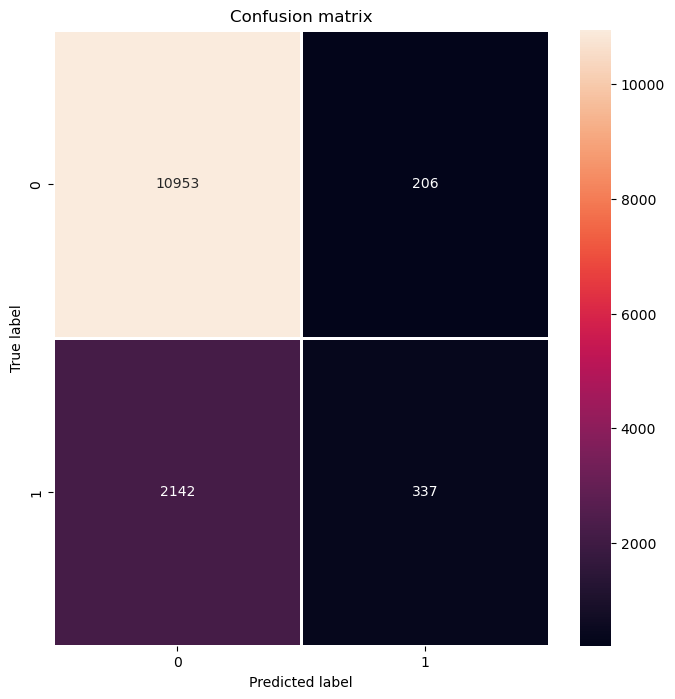



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91     44423
         1.0       0.88      0.20      0.33     10125

    accuracy                           0.85     54548
   macro avg       0.86      0.60      0.62     54548
weighted avg       0.85      0.85      0.81     54548

ROC AUC: 0.8204896818270371
Accuracy: 0.8468871452665542


In [ ]:
# Sin balanceo
print("Métricas sin balanceo:")
train_and_test(rf, X_train, y_train, X_test, y_test)

Lo probamos con cada técnica de over/under sampling:

Métricas SMOTE:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90     11159
         1.0       0.55      0.24      0.33      2479

    accuracy                           0.83     13638
   macro avg       0.70      0.60      0.62     13638
weighted avg       0.79      0.83      0.80     13638

ROC AUC: 0.7458753538686341
Accuracy: 0.8256342572224666


Confusion matrix for the test predictions


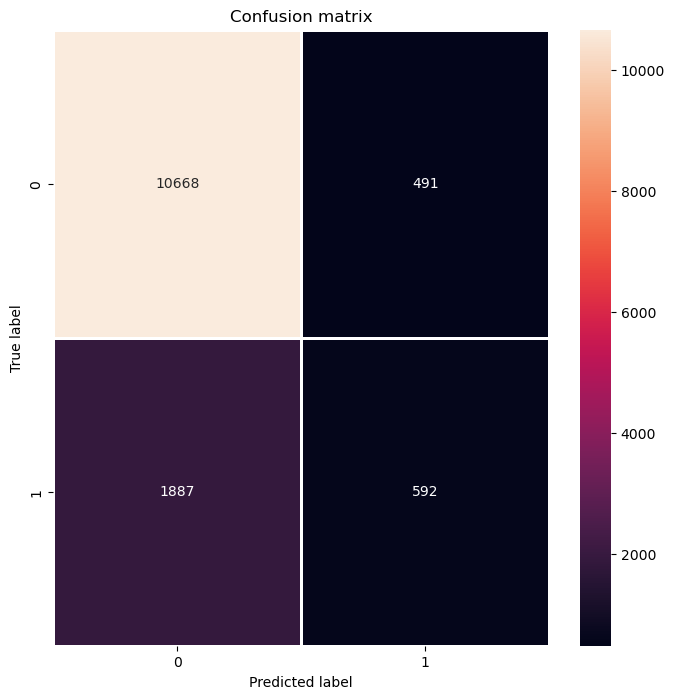



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.79      0.97      0.87     44423
         1.0       0.82      0.36      0.50     17769

    accuracy                           0.80     62192
   macro avg       0.81      0.66      0.69     62192
weighted avg       0.80      0.80      0.77     62192

ROC AUC: 0.8571885812500344
Accuracy: 0.7953916902495498


In [ ]:
print("Métricas SMOTE:")
train_and_test(rf, X_train_smote, y_train_smote, X_test, y_test)

Métricas RUS:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     11159
         1.0       0.47      0.36      0.41      2479

    accuracy                           0.81     13638
   macro avg       0.67      0.64      0.65     13638
weighted avg       0.79      0.81      0.80     13638

ROC AUC: 0.7473165123826593
Accuracy: 0.8086962897785599


Confusion matrix for the test predictions


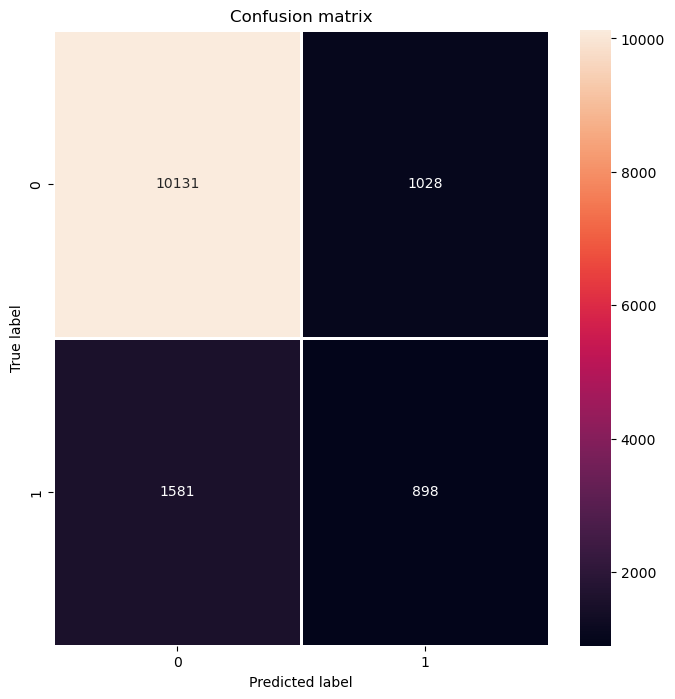



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85     20250
         1.0       0.82      0.43      0.57     10125

    accuracy                           0.78     30375
   macro avg       0.79      0.69      0.71     30375
weighted avg       0.79      0.78      0.76     30375

ROC AUC: 0.8361773290656913
Accuracy: 0.7784362139917695


In [ ]:
print("Métricas RUS:")
train_and_test(rf, X_train_rus, y_train_rus, X_test, y_test)

Métricas ENN:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     11159
         1.0       0.44      0.42      0.43      2479

    accuracy                           0.80     13638
   macro avg       0.66      0.65      0.65     13638
weighted avg       0.79      0.80      0.80     13638

ROC AUC: 0.7442445207183662
Accuracy: 0.7979909077577357


Confusion matrix for the test predictions


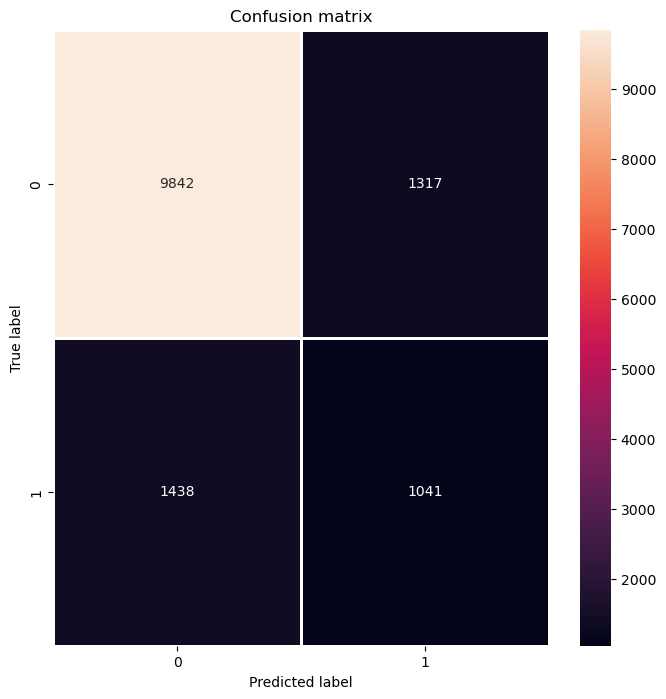



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91     29190
         1.0       0.89      0.47      0.61     10125

    accuracy                           0.85     39315
   macro avg       0.86      0.72      0.76     39315
weighted avg       0.85      0.85      0.83     39315

ROC AUC: 0.878260405432268
Accuracy: 0.8480986900674043


In [ ]:
print("Métricas ENN:")
train_and_test(rf, X_train_enn, y_train_enn, X_test, y_test)

Métricas NCR:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     11159
         1.0       0.44      0.40      0.42      2479

    accuracy                           0.80     13638
   macro avg       0.66      0.64      0.65     13638
weighted avg       0.79      0.80      0.79     13638

ROC AUC: 0.7449228596833167
Accuracy: 0.7993107493767414


Confusion matrix for the test predictions


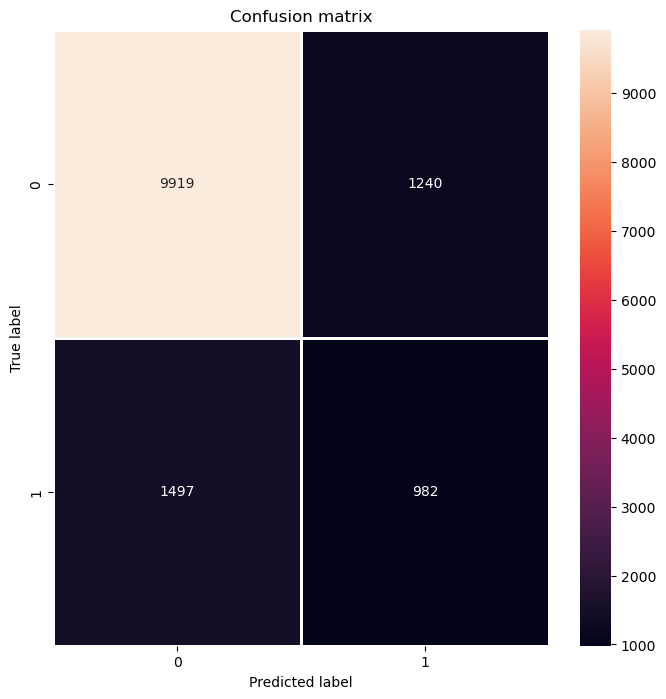



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90     28787
         1.0       0.87      0.46      0.60     10125

    accuracy                           0.84     38912
   macro avg       0.85      0.72      0.75     38912
weighted avg       0.84      0.84      0.82     38912

ROC AUC: 0.8765830220860154
Accuracy: 0.8410002055921053


In [ ]:
print("Métricas NCR:")
train_and_test(rf, X_train_ncr, y_train_ncr, X_test, y_test)

Métricas SMOTE + RUS:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89     11159
         1.0       0.48      0.33      0.39      2479

    accuracy                           0.81     13638
   macro avg       0.67      0.63      0.64     13638
weighted avg       0.79      0.81      0.80     13638

ROC AUC: 0.7454073307096033
Accuracy: 0.8143422789265288


Confusion matrix for the test predictions


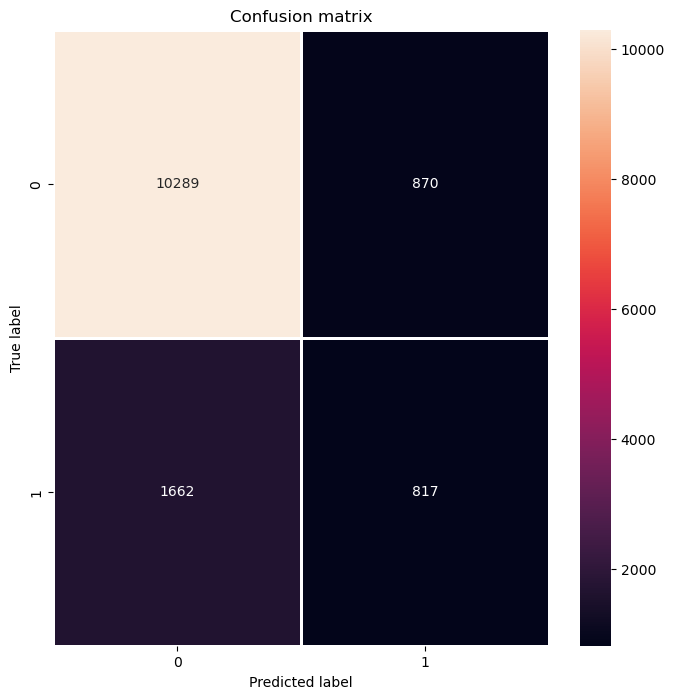



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.78      0.94      0.85     35538
         1.0       0.81      0.46      0.59     17769

    accuracy                           0.78     53307
   macro avg       0.79      0.70      0.72     53307
weighted avg       0.79      0.78      0.77     53307

ROC AUC: 0.8587318401004814
Accuracy: 0.7845686307614385


In [ ]:
print("Métricas SMOTE + RUS:")
train_and_test(rf, X_train_smote_rus, y_train_smote_rus, X_test, y_test)

### Modelo 3: XGBoost

Creamos un XGBoost con los parámetros que nos dieron los mejores resultados

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.02,
    max_depth=6,
    n_estimators=200,
)

Métricas sin balanceo:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90     11159
         1.0       0.63      0.15      0.24      2479

    accuracy                           0.83     13638
   macro avg       0.73      0.57      0.57     13638
weighted avg       0.80      0.83      0.78     13638

ROC AUC: 0.7529898517382017
Accuracy: 0.8292271594075378


Confusion matrix for the test predictions


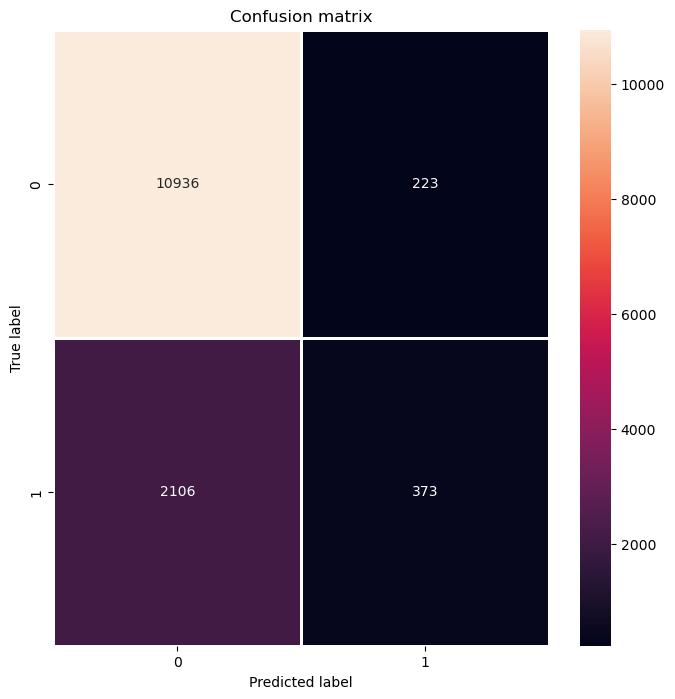



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91     44423
         1.0       0.72      0.18      0.28     10125

    accuracy                           0.83     54548
   macro avg       0.78      0.58      0.60     54548
weighted avg       0.82      0.83      0.79     54548

ROC AUC: 0.7867502581106496
Accuracy: 0.8346227176065117


In [ ]:
# Sin balanceo
print("Métricas sin balanceo:")
train_and_test(xgb, X_train, y_train, X_test, y_test)

Lo probamos con cada técnica de over/under sampling:

Métricas SMOTE:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90     11159
         1.0       0.54      0.23      0.32      2479

    accuracy                           0.82     13638
   macro avg       0.69      0.59      0.61     13638
weighted avg       0.79      0.82      0.79     13638

ROC AUC: 0.7481699036491165
Accuracy: 0.824314415603461


Confusion matrix for the test predictions


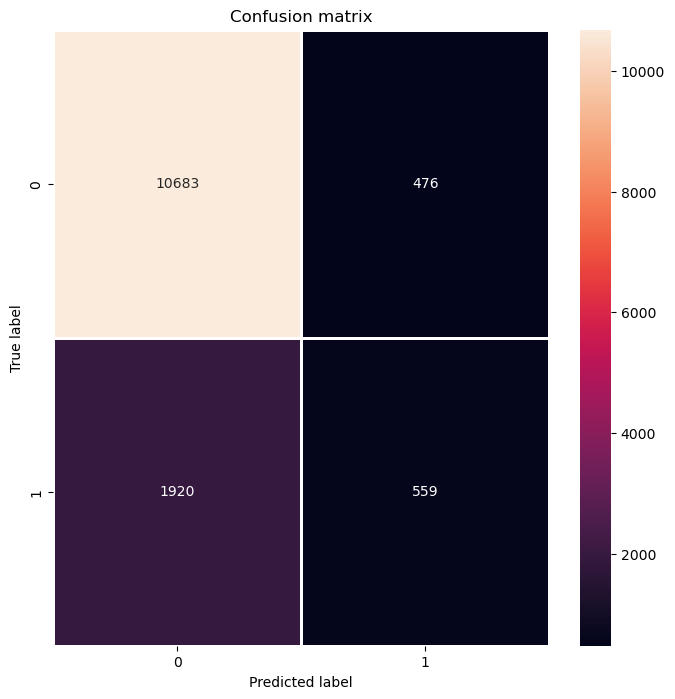



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.89     44423
         1.0       0.84      0.48      0.61     17769

    accuracy                           0.83     62192
   macro avg       0.83      0.72      0.75     62192
weighted avg       0.83      0.83      0.81     62192

ROC AUC: 0.852335733461934
Accuracy: 0.8258296887059429


In [ ]:
print("Métricas SMOTE:")
train_and_test(xgb, X_train_smote, y_train_smote, X_test, y_test)

Métricas RUS:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88     11159
         1.0       0.46      0.39      0.42      2479

    accuracy                           0.81     13638
   macro avg       0.66      0.64      0.65     13638
weighted avg       0.79      0.81      0.80     13638

ROC AUC: 0.7529202646075046
Accuracy: 0.8059099574717701


Confusion matrix for the test predictions


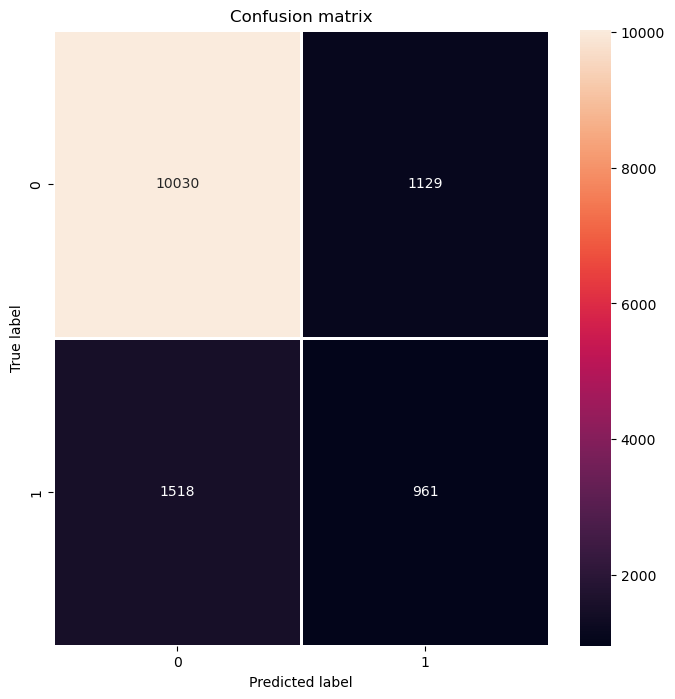



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83     20250
         1.0       0.72      0.41      0.52     10125

    accuracy                           0.75     30375
   macro avg       0.74      0.66      0.67     30375
weighted avg       0.74      0.75      0.73     30375

ROC AUC: 0.7944153830208809
Accuracy: 0.7489053497942387


In [ ]:
print("Métricas RUS:")
train_and_test(xgb, X_train_rus, y_train_rus, X_test, y_test)

Métricas ENN:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     11159
         1.0       0.44      0.43      0.44      2479

    accuracy                           0.80     13638
   macro avg       0.66      0.65      0.66     13638
weighted avg       0.79      0.80      0.80     13638

ROC AUC: 0.7513782499404171
Accuracy: 0.7954245490541135


Confusion matrix for the test predictions


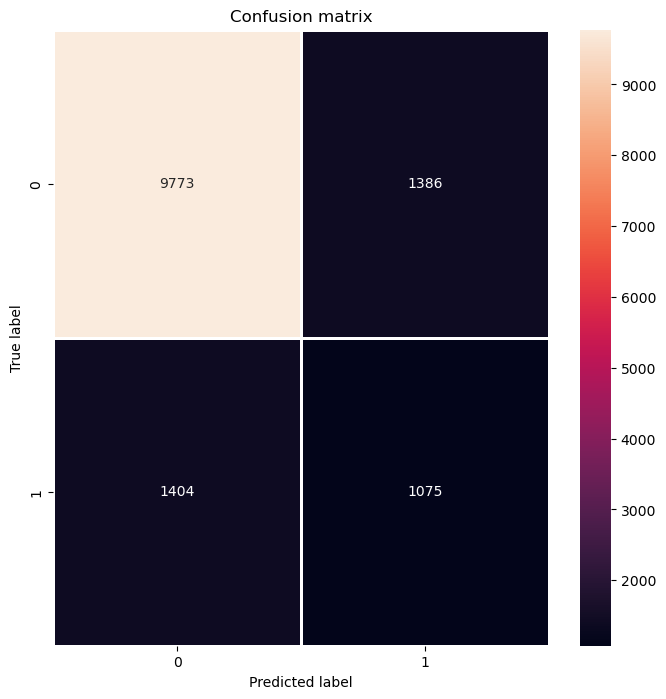



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89     29190
         1.0       0.80      0.45      0.58     10125

    accuracy                           0.83     39315
   macro avg       0.82      0.71      0.74     39315
weighted avg       0.83      0.83      0.81     39315

ROC AUC: 0.8516026763774166
Accuracy: 0.8299376828182627


In [ ]:
print("Métricas ENN:")
train_and_test(xgb, X_train_enn, y_train_enn, X_test, y_test)

Métricas NCR:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     11159
         1.0       0.44      0.42      0.43      2479

    accuracy                           0.80     13638
   macro avg       0.66      0.65      0.65     13638
weighted avg       0.79      0.80      0.80     13638

ROC AUC: 0.7495910355291646
Accuracy: 0.7967443906731192


Confusion matrix for the test predictions


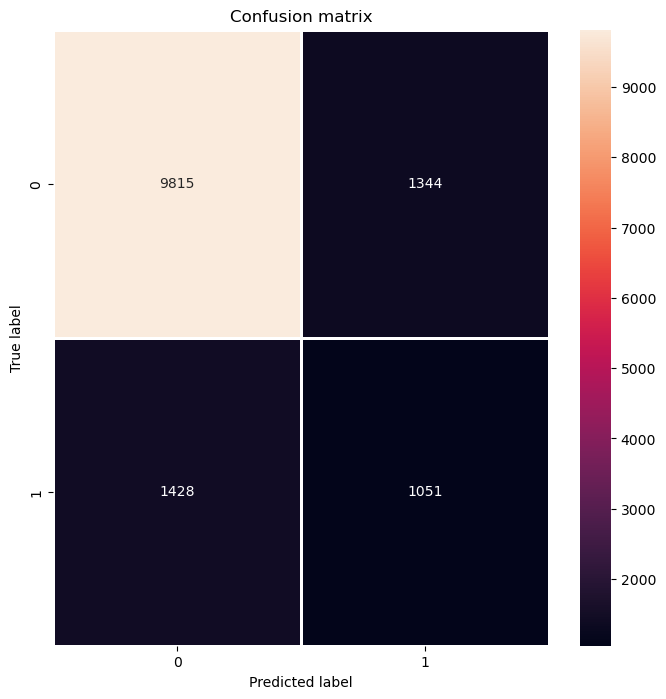



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89     28787
         1.0       0.78      0.44      0.57     10125

    accuracy                           0.82     38912
   macro avg       0.81      0.70      0.73     38912
weighted avg       0.82      0.82      0.80     38912

ROC AUC: 0.8466914738176997
Accuracy: 0.8228567023026315


In [ ]:
print("Métricas NCR:")
train_and_test(xgb, X_train_ncr, y_train_ncr, X_test, y_test)

Métricas SMOTE + RUS:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89     11159
         1.0       0.50      0.30      0.38      2479

    accuracy                           0.82     13638
   macro avg       0.68      0.62      0.64     13638
weighted avg       0.79      0.82      0.80     13638

ROC AUC: 0.7472211147525767
Accuracy: 0.818668426455492


Confusion matrix for the test predictions


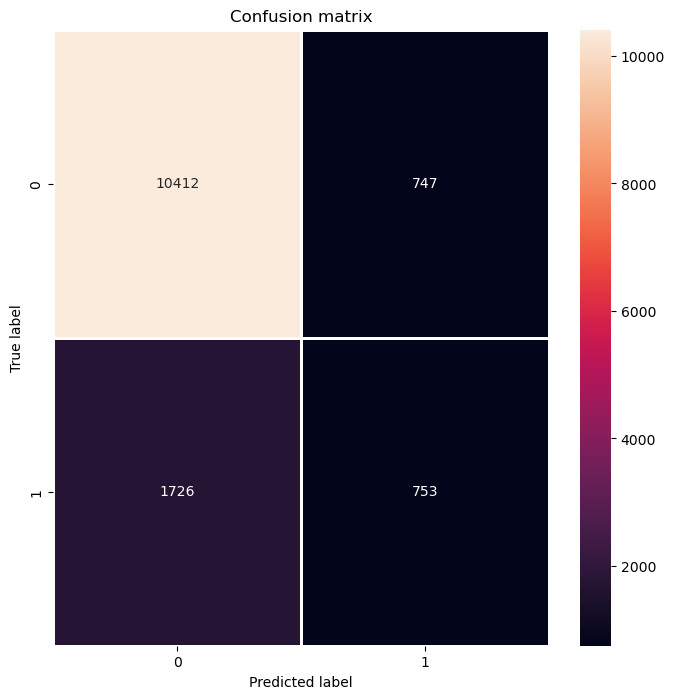



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.87     35538
         1.0       0.83      0.53      0.65     17769

    accuracy                           0.81     53307
   macro avg       0.81      0.74      0.76     53307
weighted avg       0.81      0.81      0.79     53307

ROC AUC: 0.8529965598527949
Accuracy: 0.8068171159510008


In [ ]:
print("Métricas SMOTE + RUS:")
train_and_test(xgb, X_train_smote_rus, y_train_smote_rus, X_test, y_test)

### Modelo 4: Catboost

In [ ]:
import catboost as cb

In [ ]:
best_params =  {'depth': 6, 'iterations': 400, 'learning_rate': 0.05}

In [ ]:
clf = cb.CatBoostClassifier(**best_params, random_seed=42)

Métricas sin balanceo:
0:	learn: 0.6651540	total: 159ms	remaining: 1m 3s
1:	learn: 0.6388945	total: 167ms	remaining: 33.3s
2:	learn: 0.6155575	total: 176ms	remaining: 23.2s
3:	learn: 0.5955051	total: 184ms	remaining: 18.3s
4:	learn: 0.5773567	total: 192ms	remaining: 15.2s
5:	learn: 0.5612608	total: 200ms	remaining: 13.1s
6:	learn: 0.5465457	total: 207ms	remaining: 11.6s
7:	learn: 0.5338759	total: 215ms	remaining: 10.5s
8:	learn: 0.5228456	total: 224ms	remaining: 9.74s
9:	learn: 0.5126470	total: 233ms	remaining: 9.07s
10:	learn: 0.5037888	total: 241ms	remaining: 8.51s
11:	learn: 0.4959788	total: 249ms	remaining: 8.04s
12:	learn: 0.4889842	total: 255ms	remaining: 7.6s
13:	learn: 0.4827132	total: 264ms	remaining: 7.28s
14:	learn: 0.4767601	total: 272ms	remaining: 6.97s
15:	learn: 0.4715593	total: 279ms	remaining: 6.7s
16:	learn: 0.4667815	total: 287ms	remaining: 6.46s
17:	learn: 0.4627735	total: 295ms	remaining: 6.27s
18:	learn: 0.4591929	total: 303ms	remaining: 6.08s
19:	learn: 0.4557832

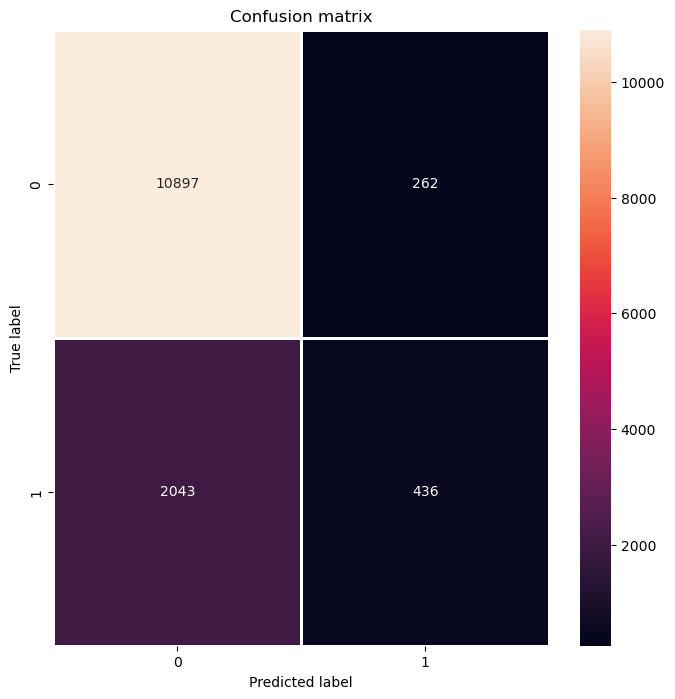



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     44423
         1.0       0.76      0.20      0.32     10125

    accuracy                           0.84     54548
   macro avg       0.80      0.60      0.62     54548
weighted avg       0.83      0.84      0.80     54548

ROC AUC: 0.791727579668301
Accuracy: 0.8405991053750825


In [ ]:
# Sin balanceo
print("Métricas sin balanceo:")
train_and_test(clf, X_train, y_train, X_test, y_test)

Lo probamos con cada técnica de over/under sampling:

Métricas SMOTE:
0:	learn: 0.6749911	total: 9.74ms	remaining: 3.89s
1:	learn: 0.6583209	total: 19ms	remaining: 3.79s
2:	learn: 0.6437801	total: 27.4ms	remaining: 3.63s
3:	learn: 0.6314433	total: 36.6ms	remaining: 3.62s
4:	learn: 0.6181411	total: 45.9ms	remaining: 3.63s
5:	learn: 0.6085331	total: 54.5ms	remaining: 3.58s
6:	learn: 0.5995957	total: 64.9ms	remaining: 3.64s
7:	learn: 0.5911026	total: 74.5ms	remaining: 3.65s
8:	learn: 0.5838884	total: 83.9ms	remaining: 3.65s
9:	learn: 0.5752315	total: 92ms	remaining: 3.59s
10:	learn: 0.5674578	total: 102ms	remaining: 3.62s
11:	learn: 0.5593969	total: 111ms	remaining: 3.59s
12:	learn: 0.5526203	total: 119ms	remaining: 3.54s
13:	learn: 0.5454928	total: 128ms	remaining: 3.52s
14:	learn: 0.5402920	total: 136ms	remaining: 3.49s
15:	learn: 0.5363114	total: 145ms	remaining: 3.47s
16:	learn: 0.5327358	total: 153ms	remaining: 3.44s
17:	learn: 0.5259748	total: 162ms	remaining: 3.44s
18:	learn: 0.5213888	total: 172ms	remaining: 3.44s
19:	learn: 0.518254

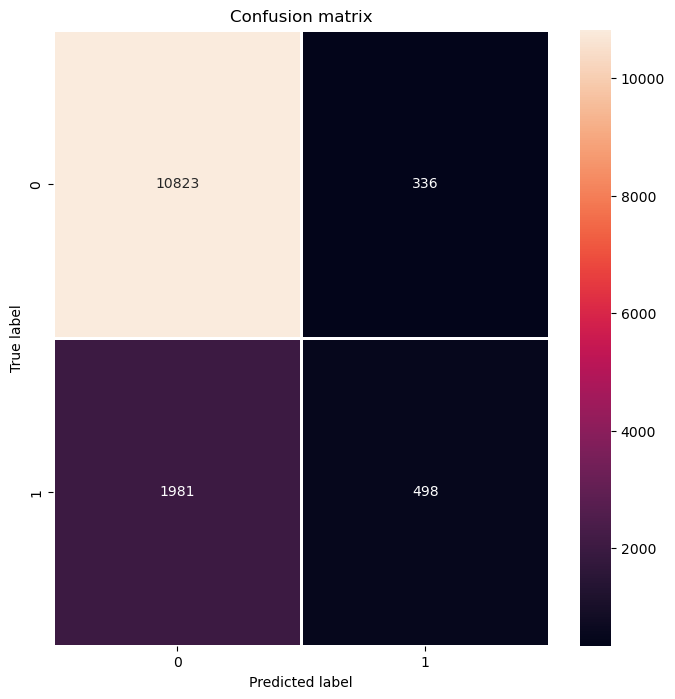



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90     44423
         1.0       0.90      0.53      0.67     17769

    accuracy                           0.85     62192
   macro avg       0.87      0.75      0.79     62192
weighted avg       0.86      0.85      0.84     62192

ROC AUC: 0.872451984167115
Accuracy: 0.8502862104450734


In [ ]:
print("Métricas SMOTE:")
train_and_test(clf, X_train_smote, y_train_smote, X_test, y_test)

Métricas RUS:
0:	learn: 0.6810110	total: 8ms	remaining: 3.19s
1:	learn: 0.6689822	total: 14.6ms	remaining: 2.9s
2:	learn: 0.6583743	total: 22.3ms	remaining: 2.96s
3:	learn: 0.6489746	total: 29.9ms	remaining: 2.96s
4:	learn: 0.6405966	total: 38.1ms	remaining: 3.01s
5:	learn: 0.6331533	total: 45.6ms	remaining: 2.99s
6:	learn: 0.6263145	total: 53.4ms	remaining: 3s
7:	learn: 0.6202349	total: 60.1ms	remaining: 2.94s
8:	learn: 0.6148032	total: 68ms	remaining: 2.95s
9:	learn: 0.6098456	total: 75.2ms	remaining: 2.93s
10:	learn: 0.6051292	total: 82.8ms	remaining: 2.93s
11:	learn: 0.6010624	total: 90.6ms	remaining: 2.93s
12:	learn: 0.5971423	total: 97.8ms	remaining: 2.91s
13:	learn: 0.5936221	total: 106ms	remaining: 2.91s
14:	learn: 0.5904637	total: 112ms	remaining: 2.88s
15:	learn: 0.5877284	total: 119ms	remaining: 2.86s
16:	learn: 0.5847861	total: 127ms	remaining: 2.85s
17:	learn: 0.5823228	total: 134ms	remaining: 2.85s
18:	learn: 0.5802360	total: 141ms	remaining: 2.83s
19:	learn: 0.5777926	to

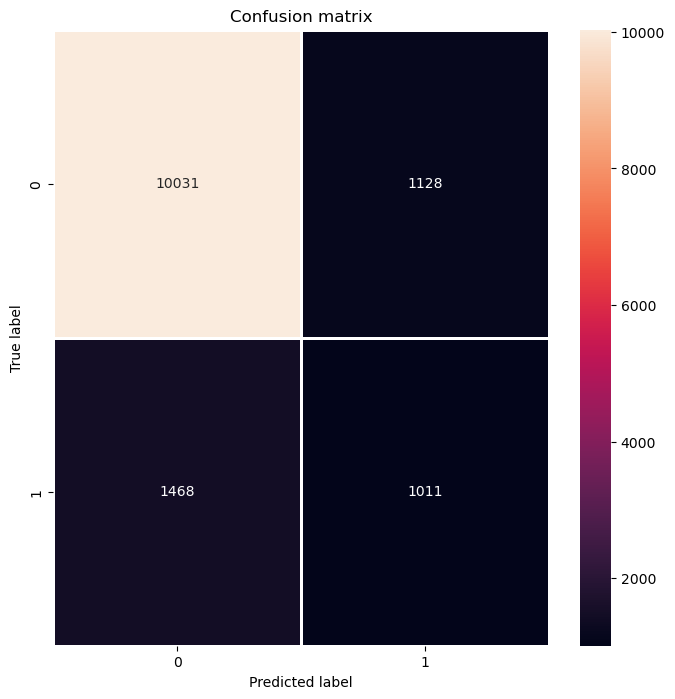



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.76      0.92      0.84     20250
         1.0       0.74      0.43      0.54     10125

    accuracy                           0.76     30375
   macro avg       0.75      0.68      0.69     30375
weighted avg       0.76      0.76      0.74     30375

ROC AUC: 0.8013534180765127
Accuracy: 0.7591769547325102


In [ ]:
print("Métricas RUS:")
train_and_test(clf, X_train_rus, y_train_rus, X_test, y_test)

Métricas ENN:
0:	learn: 0.6682598	total: 7.57ms	remaining: 3.02s
1:	learn: 0.6460316	total: 14.3ms	remaining: 2.85s
2:	learn: 0.6252229	total: 22.1ms	remaining: 2.92s
3:	learn: 0.6069709	total: 29.8ms	remaining: 2.94s
4:	learn: 0.5908142	total: 36.2ms	remaining: 2.86s
5:	learn: 0.5760545	total: 43.8ms	remaining: 2.87s
6:	learn: 0.5626479	total: 51.2ms	remaining: 2.87s
7:	learn: 0.5510394	total: 58ms	remaining: 2.84s
8:	learn: 0.5407829	total: 64.4ms	remaining: 2.8s
9:	learn: 0.5312938	total: 71.5ms	remaining: 2.79s
10:	learn: 0.5230983	total: 78.3ms	remaining: 2.77s
11:	learn: 0.5157714	total: 85.6ms	remaining: 2.77s
12:	learn: 0.5088771	total: 92.8ms	remaining: 2.76s
13:	learn: 0.5026573	total: 99.6ms	remaining: 2.74s
14:	learn: 0.4964447	total: 107ms	remaining: 2.74s
15:	learn: 0.4914556	total: 114ms	remaining: 2.73s
16:	learn: 0.4865445	total: 120ms	remaining: 2.71s
17:	learn: 0.4821369	total: 127ms	remaining: 2.69s
18:	learn: 0.4783573	total: 134ms	remaining: 2.7s
19:	learn: 0.4744

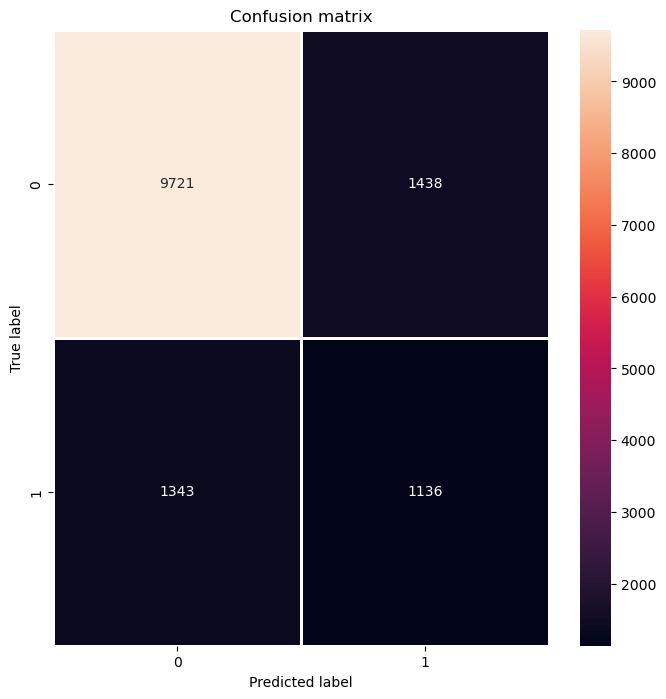



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90     29190
         1.0       0.81      0.48      0.60     10125

    accuracy                           0.84     39315
   macro avg       0.83      0.72      0.75     39315
weighted avg       0.83      0.84      0.82     39315

ROC AUC: 0.8606475479933513
Accuracy: 0.837517486964263


In [ ]:
print("Métricas ENN:")
train_and_test(clf, X_train_enn, y_train_enn, X_test, y_test)

Métricas NCR:
0:	learn: 0.6698441	total: 6.43ms	remaining: 2.56s
1:	learn: 0.6485062	total: 13.6ms	remaining: 2.7s
2:	learn: 0.6284856	total: 21.2ms	remaining: 2.8s
3:	learn: 0.6110594	total: 28.5ms	remaining: 2.82s
4:	learn: 0.5950502	total: 36ms	remaining: 2.84s
5:	learn: 0.5813407	total: 42.7ms	remaining: 2.81s
6:	learn: 0.5684991	total: 49.5ms	remaining: 2.78s
7:	learn: 0.5571251	total: 57.2ms	remaining: 2.8s
8:	learn: 0.5471557	total: 64.3ms	remaining: 2.79s
9:	learn: 0.5383313	total: 70.2ms	remaining: 2.74s
10:	learn: 0.5305500	total: 78ms	remaining: 2.76s
11:	learn: 0.5228451	total: 85.6ms	remaining: 2.77s
12:	learn: 0.5155565	total: 94.2ms	remaining: 2.8s
13:	learn: 0.5095971	total: 101ms	remaining: 2.79s
14:	learn: 0.5040686	total: 108ms	remaining: 2.76s
15:	learn: 0.4990253	total: 115ms	remaining: 2.75s
16:	learn: 0.4947607	total: 122ms	remaining: 2.75s
17:	learn: 0.4910364	total: 129ms	remaining: 2.75s
18:	learn: 0.4874094	total: 136ms	remaining: 2.72s
19:	learn: 0.4838748	t

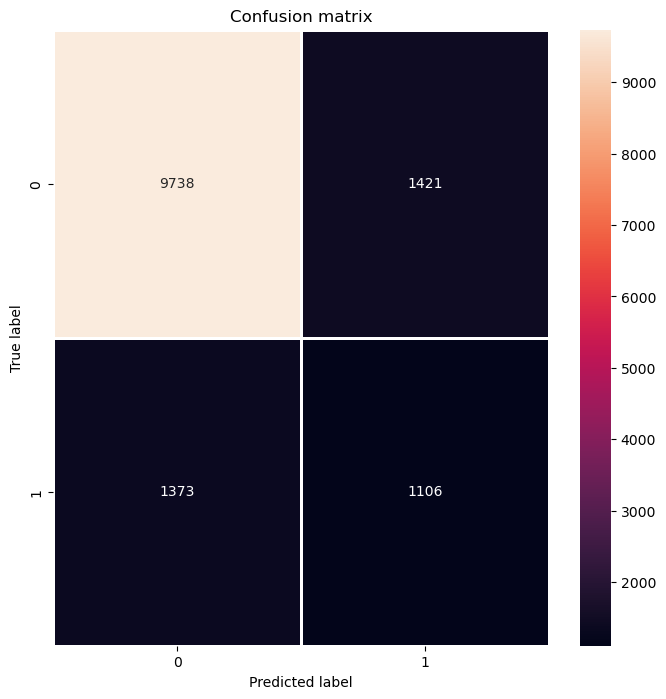



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.89     28787
         1.0       0.80      0.47      0.59     10125

    accuracy                           0.83     38912
   macro avg       0.82      0.72      0.74     38912
weighted avg       0.83      0.83      0.82     38912

ROC AUC: 0.8572602190546401
Accuracy: 0.8321597450657895


In [ ]:
print("Métricas NCR:")
train_and_test(clf, X_train_ncr, y_train_ncr, X_test, y_test)

Métricas SMOTE + RUS:
0:	learn: 0.6789646	total: 9.67ms	remaining: 3.86s
1:	learn: 0.6646091	total: 19.7ms	remaining: 3.91s
2:	learn: 0.6520765	total: 29ms	remaining: 3.83s
3:	learn: 0.6416289	total: 38.3ms	remaining: 3.79s
4:	learn: 0.6330317	total: 47.8ms	remaining: 3.77s
5:	learn: 0.6226985	total: 57.3ms	remaining: 3.76s
6:	learn: 0.6126969	total: 67ms	remaining: 3.76s
7:	learn: 0.6060982	total: 74.9ms	remaining: 3.67s
8:	learn: 0.5997860	total: 84.3ms	remaining: 3.66s
9:	learn: 0.5921024	total: 94ms	remaining: 3.66s
10:	learn: 0.5869051	total: 102ms	remaining: 3.6s
11:	learn: 0.5826517	total: 112ms	remaining: 3.63s
12:	learn: 0.5770712	total: 120ms	remaining: 3.58s
13:	learn: 0.5704724	total: 127ms	remaining: 3.51s
14:	learn: 0.5665682	total: 135ms	remaining: 3.48s
15:	learn: 0.5620709	total: 144ms	remaining: 3.46s
16:	learn: 0.5591101	total: 150ms	remaining: 3.39s
17:	learn: 0.5548951	total: 158ms	remaining: 3.36s
18:	learn: 0.5523076	total: 165ms	remaining: 3.31s
19:	learn: 0.549

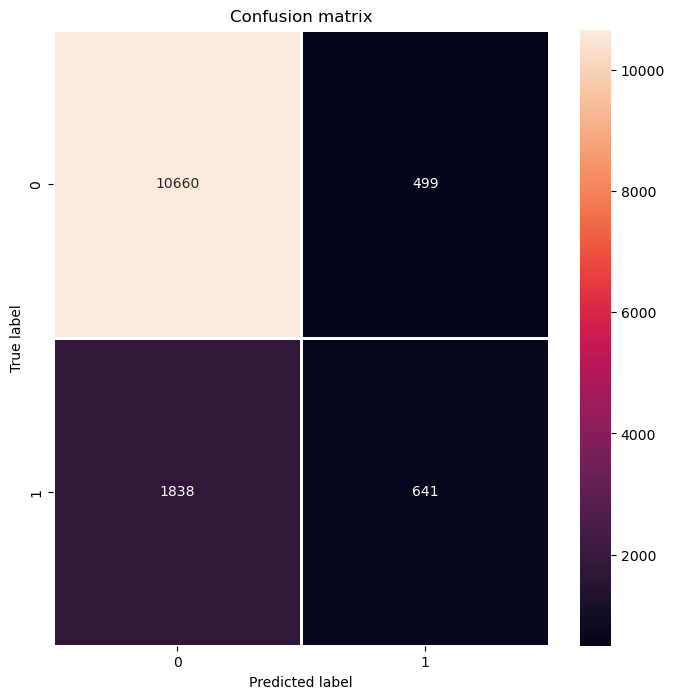



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88     35538
         1.0       0.89      0.57      0.69     17769

    accuracy                           0.83     53307
   macro avg       0.85      0.77      0.79     53307
weighted avg       0.84      0.83      0.82     53307

ROC AUC: 0.8738509646946723
Accuracy: 0.8313917496764027


In [ ]:
print("Métricas SMOTE + RUS:")
train_and_test(clf, X_train_smote_rus, y_train_smote_rus, X_test, y_test)

## 5.2. Modelos Extra

Estos son modelos que pueden ser o muy ismples o muy complejos para el problema a mano y es preferible utilizar los otros.

### Modelo de Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)

Métricas sin balanceo:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90     11159
         1.0       0.60      0.14      0.23      2479

    accuracy                           0.83     13638
   macro avg       0.72      0.56      0.56     13638
weighted avg       0.79      0.83      0.78     13638

ROC AUC: 0.7281493608051517
Accuracy: 0.8267341252383047


Confusion matrix for the test predictions


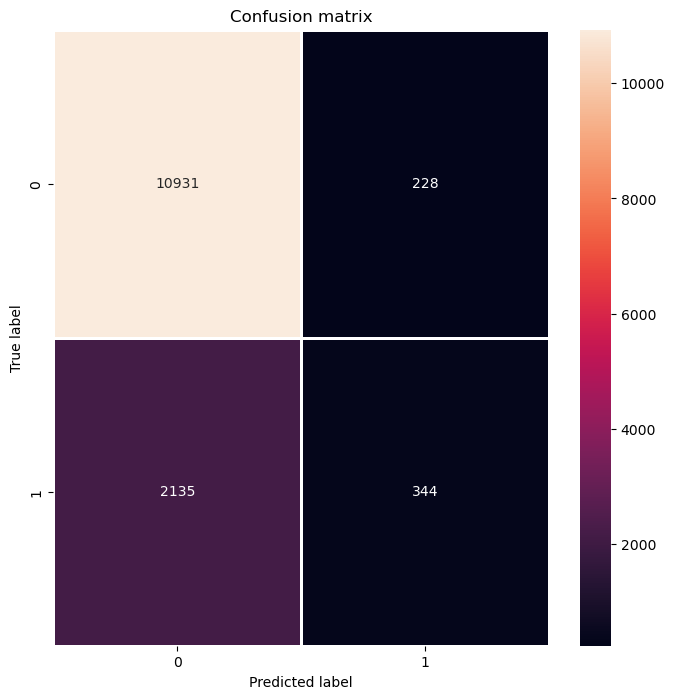



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90     44423
         1.0       0.60      0.14      0.23     10125

    accuracy                           0.82     54548
   macro avg       0.72      0.56      0.56     54548
weighted avg       0.79      0.82      0.77     54548

ROC AUC: 0.7265201370772508
Accuracy: 0.8228349343697294


In [ ]:
# Sin balanceo
print("Métricas sin balanceo:")
train_and_test(lr, X_train, y_train, X_test, y_test)

Lo probamos con cada técnica de over/under sampling:

Métricas SMOTE:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     11159
         1.0       0.52      0.29      0.37      2479

    accuracy                           0.82     13638
   macro avg       0.69      0.61      0.63     13638
weighted avg       0.79      0.82      0.80     13638

ROC AUC: 0.7284624125203912
Accuracy: 0.8221880041061739


Confusion matrix for the test predictions


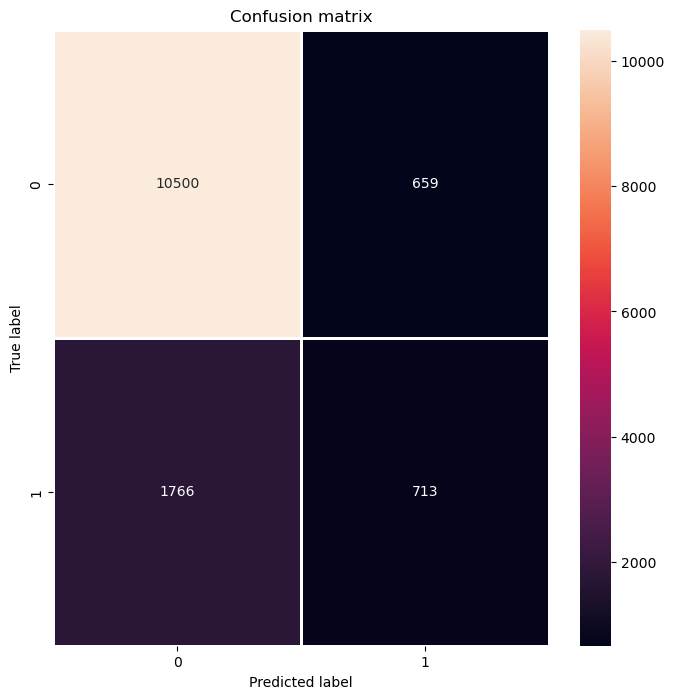



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.76      0.94      0.84     44423
         1.0       0.63      0.26      0.37     17769

    accuracy                           0.75     62192
   macro avg       0.70      0.60      0.61     62192
weighted avg       0.72      0.75      0.71     62192

ROC AUC: 0.7281829146078094
Accuracy: 0.7455621301775148


In [ ]:
print("Métricas SMOTE:")
train_and_test(lr, X_train_smote, y_train_smote, X_test, y_test)

Métricas RUS:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89     11159
         1.0       0.47      0.35      0.40      2479

    accuracy                           0.81     13638
   macro avg       0.66      0.63      0.64     13638
weighted avg       0.79      0.81      0.80     13638

ROC AUC: 0.7285058638092733
Accuracy: 0.8085496407097815


Confusion matrix for the test predictions


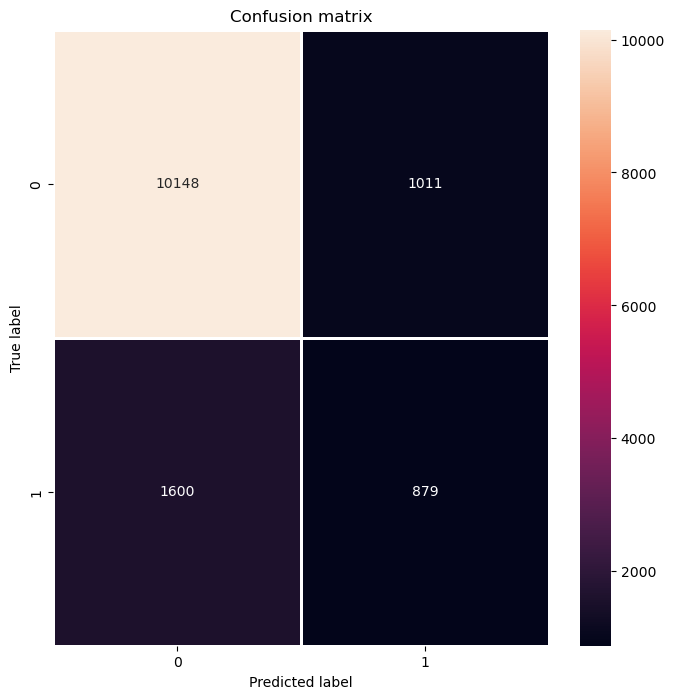



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.73      0.91      0.81     20250
         1.0       0.65      0.34      0.44     10125

    accuracy                           0.72     30375
   macro avg       0.69      0.62      0.63     30375
weighted avg       0.71      0.72      0.69     30375

ROC AUC: 0.7274324328608444
Accuracy: 0.7186502057613169


In [ ]:
print("Métricas RUS:")
train_and_test(lr, X_train_rus, y_train_rus, X_test, y_test)

Métricas ENN:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     11159
         1.0       0.44      0.42      0.43      2479

    accuracy                           0.80     13638
   macro avg       0.65      0.65      0.65     13638
weighted avg       0.79      0.80      0.79     13638

ROC AUC: 0.7290180612403622
Accuracy: 0.795937820794838


Confusion matrix for the test predictions


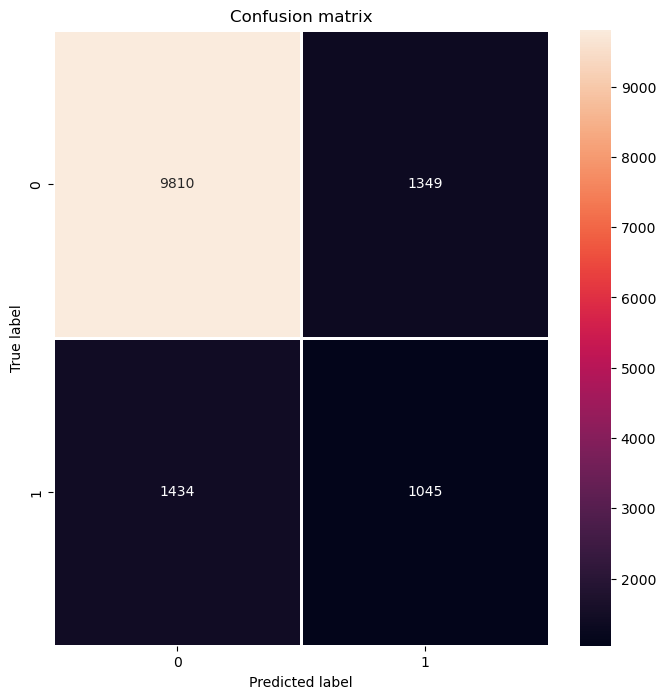



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88     29190
         1.0       0.73      0.40      0.51     10125

    accuracy                           0.81     39315
   macro avg       0.77      0.67      0.70     39315
weighted avg       0.80      0.81      0.79     39315

ROC AUC: 0.7977235498373788
Accuracy: 0.8068421721989063


In [ ]:
print("Métricas ENN:")
train_and_test(lr, X_train_enn, y_train_enn, X_test, y_test)

Métricas NCR:
Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     11159
         1.0       0.45      0.40      0.42      2479

    accuracy                           0.80     13638
   macro avg       0.66      0.64      0.65     13638
weighted avg       0.79      0.80      0.80     13638

ROC AUC: 0.7282737139114362
Accuracy: 0.80129051180525


Confusion matrix for the test predictions


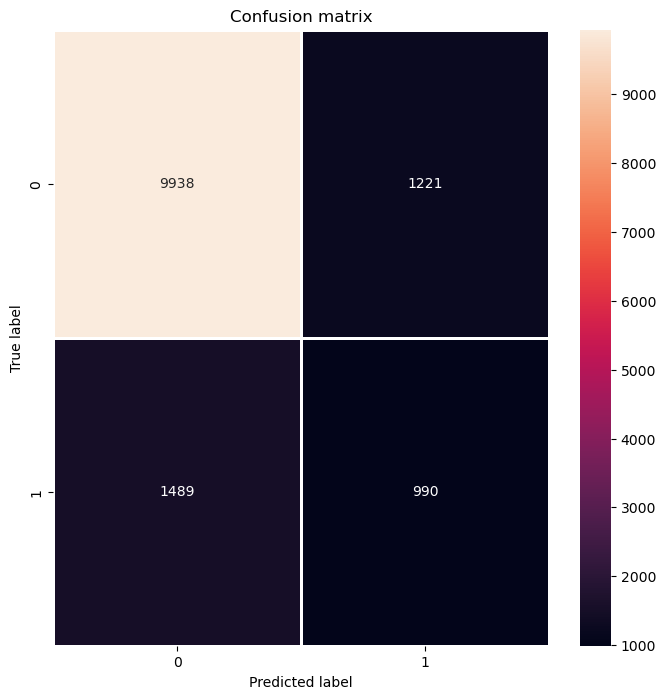



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87     28787
         1.0       0.72      0.38      0.49     10125

    accuracy                           0.80     38912
   macro avg       0.76      0.66      0.68     38912
weighted avg       0.79      0.80      0.78     38912

ROC AUC: 0.7893885297161314
Accuracy: 0.7993421052631579


In [ ]:
print("Métricas NCR:")
train_and_test(lr, X_train_ncr, y_train_ncr, X_test, y_test)

### Modelo de Multilayer Perceptron

In [ ]:
cant_columnas = len(X_train_ncr.columns)
cant_columnas

23

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(cant_columnas,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

from keras.metrics import Accuracy, AUC, Precision, Recall
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC()])

# Train the model
model.fit(X_train_ncr, y_train_ncr, epochs=100, batch_size=15)


Epoch 1/100
2595/2595 [==============================] - 3s 758us/step - loss: 0.4725 - auc: 0.7684
Epoch 2/100
2595/2595 [==============================] - 2s 759us/step - loss: 0.4547 - auc: 0.7898
Epoch 3/100
2595/2595 [==============================] - 2s 750us/step - loss: 0.4529 - auc: 0.7916
Epoch 4/100
2595/2595 [==============================] - 2s 752us/step - loss: 0.4508 - auc: 0.7939
Epoch 5/100
2595/2595 [==============================] - 2s 747us/step - loss: 0.4500 - auc: 0.7946
Epoch 6/100
2595/2595 [==============================] - 2s 758us/step - loss: 0.4490 - auc: 0.7954
Epoch 7/100
2595/2595 [==============================] - 2s 758us/step - loss: 0.4479 - auc: 0.7971
Epoch 8/100
2595/2595 [==============================] - 2s 818us/step - loss: 0.4479 - auc: 0.7969
Epoch 9/100
2595/2595 [==============================] - 2s 751us/step - loss: 0.4471 - auc: 0.7976
Epoch 10/100
2595/2595 [==============================] - 2s 753us/step - loss: 0.4462 - auc: 0.7988

In [ ]:
y_pred_proba = model.predict(X_test)
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

427/427 [==============================] - 0s 566us/step
ROC AUC: 0.7466421136760184


## 5.3. Modelos de ensamble

También se probaron distintos modelos de ensamble de modelos

### Modelo de  Voting Classifier de XGBoost, Random Forest y Catboost

In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.02,
    max_depth=6,
    n_estimators=200,
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
)

clf = cb.CatBoostClassifier(
    depth = 6,
    iterations = 400,
    learning_rate = 0.05,
    random_seed=42
)

In [ ]:
from sklearn.ensemble import VotingClassifier

ensamble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb),  ('catboost', clf)], voting='soft', flatten_transform=True)

Métricas sin balanceo:
0:	learn: 0.6651540	total: 7.87ms	remaining: 3.14s
1:	learn: 0.6388945	total: 15.9ms	remaining: 3.17s
2:	learn: 0.6155575	total: 23.3ms	remaining: 3.08s
3:	learn: 0.5955051	total: 30.2ms	remaining: 2.99s
4:	learn: 0.5773567	total: 37.4ms	remaining: 2.95s
5:	learn: 0.5612608	total: 44.6ms	remaining: 2.93s
6:	learn: 0.5465457	total: 51.9ms	remaining: 2.91s
7:	learn: 0.5338759	total: 58.6ms	remaining: 2.87s
8:	learn: 0.5228456	total: 66ms	remaining: 2.87s
9:	learn: 0.5126470	total: 73.3ms	remaining: 2.86s
10:	learn: 0.5037888	total: 80.8ms	remaining: 2.86s
11:	learn: 0.4959788	total: 88ms	remaining: 2.84s
12:	learn: 0.4889842	total: 94.9ms	remaining: 2.82s
13:	learn: 0.4827132	total: 102ms	remaining: 2.81s
14:	learn: 0.4767601	total: 109ms	remaining: 2.79s
15:	learn: 0.4715593	total: 116ms	remaining: 2.79s
16:	learn: 0.4667815	total: 123ms	remaining: 2.78s
17:	learn: 0.4627735	total: 130ms	remaining: 2.77s
18:	learn: 0.4591929	total: 137ms	remaining: 2.75s
19:	learn

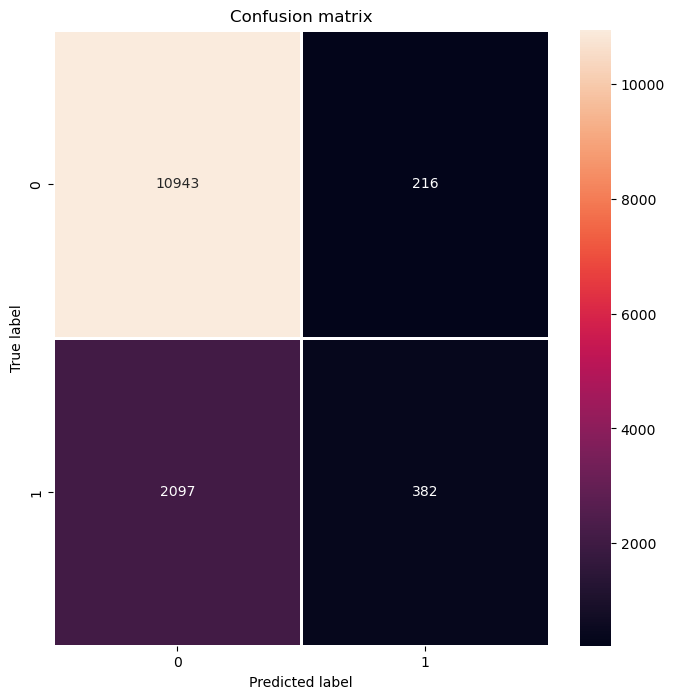



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     44423
         1.0       0.80      0.19      0.31     10125

    accuracy                           0.84     54548
   macro avg       0.82      0.59      0.61     54548
weighted avg       0.83      0.84      0.80     54548

ROC AUC: 0.8026574066431498
Accuracy: 0.8412774070543375


In [ ]:
# Sin balanceo
print("Métricas sin balanceo:")
train_and_test(ensamble, X_train, y_train, X_test, y_test)

Lo probamos con cada técnica de over/under sampling:

Métricas SMOTE:
0:	learn: 0.6749911	total: 8.91ms	remaining: 3.55s
1:	learn: 0.6583209	total: 17.2ms	remaining: 3.43s
2:	learn: 0.6437801	total: 24.9ms	remaining: 3.29s
3:	learn: 0.6314433	total: 31.8ms	remaining: 3.14s
4:	learn: 0.6181411	total: 39.7ms	remaining: 3.13s
5:	learn: 0.6085331	total: 47.6ms	remaining: 3.13s
6:	learn: 0.5995957	total: 55.7ms	remaining: 3.13s
7:	learn: 0.5911026	total: 64.3ms	remaining: 3.15s
8:	learn: 0.5838884	total: 73.3ms	remaining: 3.18s
9:	learn: 0.5752315	total: 82.3ms	remaining: 3.21s
10:	learn: 0.5674578	total: 90.8ms	remaining: 3.21s
11:	learn: 0.5593969	total: 99.2ms	remaining: 3.21s
12:	learn: 0.5526203	total: 107ms	remaining: 3.19s
13:	learn: 0.5454928	total: 115ms	remaining: 3.18s
14:	learn: 0.5402920	total: 123ms	remaining: 3.15s
15:	learn: 0.5363114	total: 131ms	remaining: 3.14s
16:	learn: 0.5327358	total: 139ms	remaining: 3.14s
17:	learn: 0.5259748	total: 147ms	remaining: 3.12s
18:	learn: 0.5213888	total: 155ms	remaining: 3.12s
19:	learn: 0.

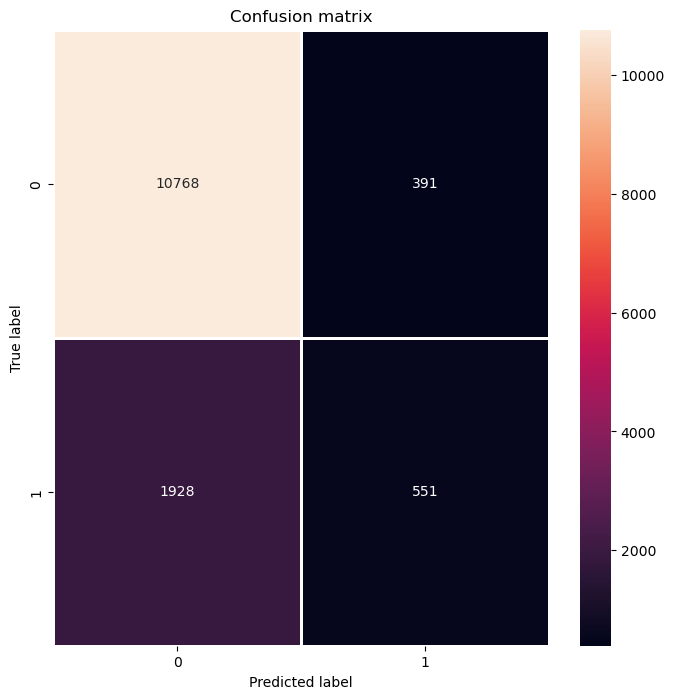



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.90     44423
         1.0       0.88      0.52      0.65     17769

    accuracy                           0.84     62192
   macro avg       0.86      0.74      0.78     62192
weighted avg       0.85      0.84      0.83     62192

ROC AUC: 0.8755591899615287
Accuracy: 0.8424395420632879


In [ ]:
print("Métricas SMOTE:")
train_and_test(ensamble, X_train_smote, y_train_smote, X_test, y_test)

Métricas RUS:
0:	learn: 0.6810110	total: 6.14ms	remaining: 2.45s
1:	learn: 0.6689822	total: 12.3ms	remaining: 2.44s
2:	learn: 0.6583743	total: 18.4ms	remaining: 2.43s
3:	learn: 0.6489746	total: 24.9ms	remaining: 2.46s
4:	learn: 0.6405966	total: 30.8ms	remaining: 2.43s
5:	learn: 0.6331533	total: 36.9ms	remaining: 2.43s
6:	learn: 0.6263145	total: 42.9ms	remaining: 2.41s
7:	learn: 0.6202349	total: 49ms	remaining: 2.4s
8:	learn: 0.6148032	total: 55.1ms	remaining: 2.4s
9:	learn: 0.6098456	total: 61.4ms	remaining: 2.39s
10:	learn: 0.6051292	total: 67.7ms	remaining: 2.39s
11:	learn: 0.6010624	total: 73.7ms	remaining: 2.38s
12:	learn: 0.5971423	total: 79.7ms	remaining: 2.37s
13:	learn: 0.5936221	total: 85.8ms	remaining: 2.37s
14:	learn: 0.5904637	total: 91.7ms	remaining: 2.35s
15:	learn: 0.5877284	total: 97.8ms	remaining: 2.35s
16:	learn: 0.5847861	total: 104ms	remaining: 2.34s
17:	learn: 0.5823228	total: 111ms	remaining: 2.35s
18:	learn: 0.5802360	total: 117ms	remaining: 2.34s
19:	learn: 0.57

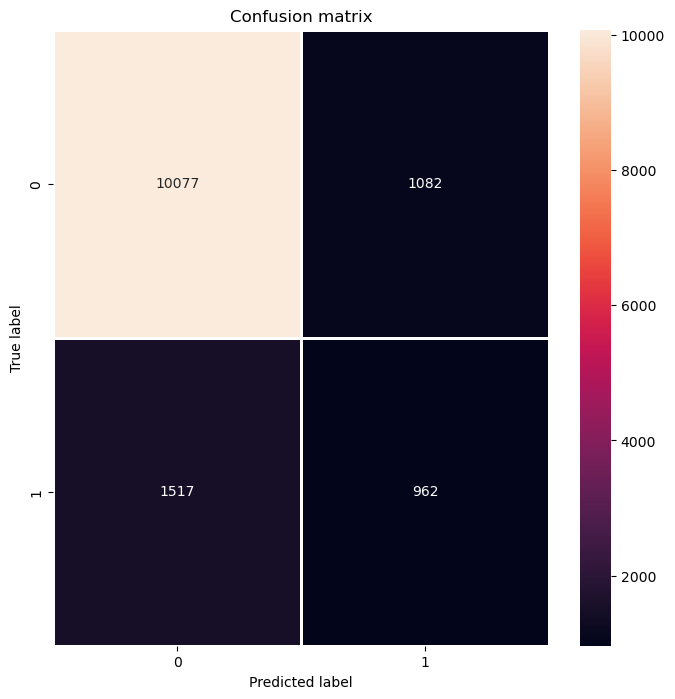



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84     20250
         1.0       0.76      0.42      0.54     10125

    accuracy                           0.76     30375
   macro avg       0.76      0.68      0.69     30375
weighted avg       0.76      0.76      0.74     30375

ROC AUC: 0.8138188983386679
Accuracy: 0.7627325102880659


In [ ]:
print("Métricas RUS:")
train_and_test(ensamble, X_train_rus, y_train_rus, X_test, y_test)

Métricas ENN:
0:	learn: 0.6682598	total: 7ms	remaining: 2.79s
1:	learn: 0.6460316	total: 13.9ms	remaining: 2.77s
2:	learn: 0.6252229	total: 20.3ms	remaining: 2.69s
3:	learn: 0.6069709	total: 26.9ms	remaining: 2.67s
4:	learn: 0.5908142	total: 33.1ms	remaining: 2.62s
5:	learn: 0.5760545	total: 40.5ms	remaining: 2.66s
6:	learn: 0.5626479	total: 47.1ms	remaining: 2.65s
7:	learn: 0.5510394	total: 53.8ms	remaining: 2.63s
8:	learn: 0.5407829	total: 60.3ms	remaining: 2.62s
9:	learn: 0.5312938	total: 66.9ms	remaining: 2.61s
10:	learn: 0.5230983	total: 73.6ms	remaining: 2.6s
11:	learn: 0.5157714	total: 80ms	remaining: 2.59s
12:	learn: 0.5088771	total: 86.5ms	remaining: 2.57s
13:	learn: 0.5026573	total: 93ms	remaining: 2.56s
14:	learn: 0.4964447	total: 99.5ms	remaining: 2.55s
15:	learn: 0.4914556	total: 106ms	remaining: 2.54s
16:	learn: 0.4865445	total: 112ms	remaining: 2.53s
17:	learn: 0.4821369	total: 119ms	remaining: 2.52s
18:	learn: 0.4783573	total: 126ms	remaining: 2.52s
19:	learn: 0.4744634

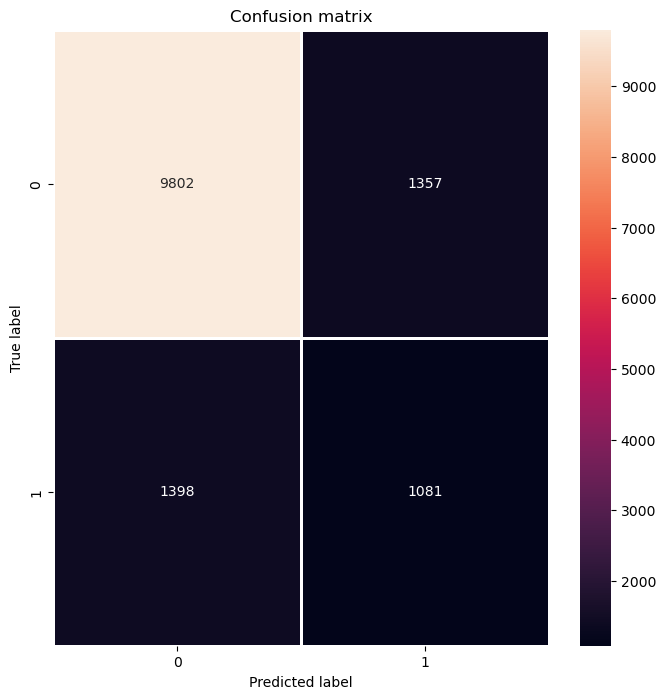



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90     29190
         1.0       0.83      0.46      0.60     10125

    accuracy                           0.84     39315
   macro avg       0.84      0.72      0.75     39315
weighted avg       0.84      0.84      0.82     39315

ROC AUC: 0.8668097158252235
Accuracy: 0.8384840391707999


In [ ]:
print("Métricas ENN:")
train_and_test(ensamble, X_train_enn, y_train_enn, X_test, y_test)

Métricas NCR:
0:	learn: 0.6698441	total: 7.48ms	remaining: 2.98s
1:	learn: 0.6485062	total: 14.5ms	remaining: 2.88s
2:	learn: 0.6284856	total: 21.5ms	remaining: 2.84s
3:	learn: 0.6110594	total: 28.2ms	remaining: 2.79s
4:	learn: 0.5950502	total: 35ms	remaining: 2.76s
5:	learn: 0.5813407	total: 42.4ms	remaining: 2.78s
6:	learn: 0.5684991	total: 49.6ms	remaining: 2.78s
7:	learn: 0.5571251	total: 56.6ms	remaining: 2.77s
8:	learn: 0.5471557	total: 63.6ms	remaining: 2.76s
9:	learn: 0.5383313	total: 70ms	remaining: 2.73s
10:	learn: 0.5305500	total: 77.3ms	remaining: 2.73s
11:	learn: 0.5228451	total: 84.2ms	remaining: 2.72s
12:	learn: 0.5155565	total: 91.2ms	remaining: 2.71s
13:	learn: 0.5095971	total: 98.5ms	remaining: 2.71s
14:	learn: 0.5040686	total: 105ms	remaining: 2.7s
15:	learn: 0.4990253	total: 113ms	remaining: 2.7s
16:	learn: 0.4947607	total: 120ms	remaining: 2.7s
17:	learn: 0.4910364	total: 127ms	remaining: 2.69s
18:	learn: 0.4874094	total: 134ms	remaining: 2.69s
19:	learn: 0.4838748

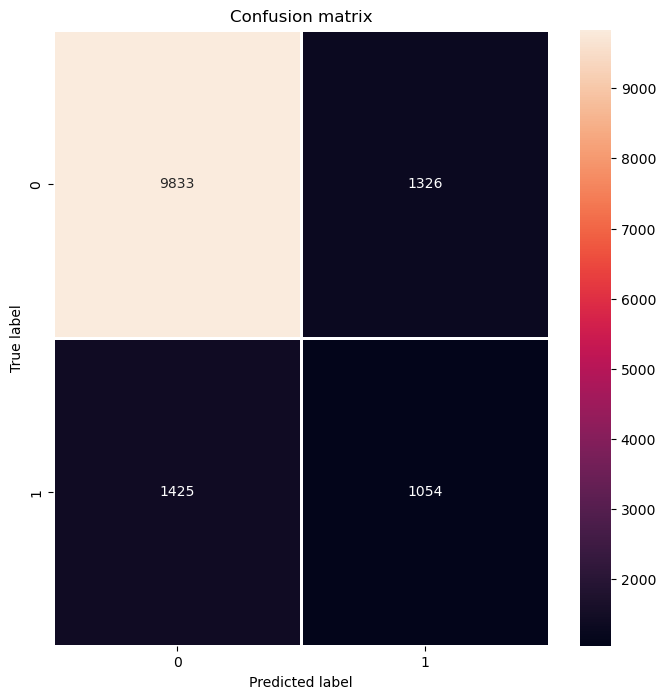



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89     28787
         1.0       0.82      0.46      0.59     10125

    accuracy                           0.83     38912
   macro avg       0.83      0.71      0.74     38912
weighted avg       0.83      0.83      0.81     38912

ROC AUC: 0.8637445554770736
Accuracy: 0.8325452302631579


In [ ]:
print("Métricas NCR:")
train_and_test(ensamble, X_train_ncr, y_train_ncr, X_test, y_test)

Métricas SMOTE + RUS:
0:	learn: 0.6789646	total: 8.87ms	remaining: 3.54s
1:	learn: 0.6646091	total: 17ms	remaining: 3.38s
2:	learn: 0.6520765	total: 25.5ms	remaining: 3.38s
3:	learn: 0.6416289	total: 33.7ms	remaining: 3.34s
4:	learn: 0.6330317	total: 43.5ms	remaining: 3.44s
5:	learn: 0.6226985	total: 52.9ms	remaining: 3.47s
6:	learn: 0.6126969	total: 64.1ms	remaining: 3.6s
7:	learn: 0.6060982	total: 72.9ms	remaining: 3.57s
8:	learn: 0.5997860	total: 83.2ms	remaining: 3.61s
9:	learn: 0.5921024	total: 92.4ms	remaining: 3.6s
10:	learn: 0.5869051	total: 101ms	remaining: 3.58s
11:	learn: 0.5826517	total: 111ms	remaining: 3.59s
12:	learn: 0.5770712	total: 121ms	remaining: 3.59s
13:	learn: 0.5704724	total: 130ms	remaining: 3.57s
14:	learn: 0.5665682	total: 138ms	remaining: 3.55s
15:	learn: 0.5620709	total: 147ms	remaining: 3.54s
16:	learn: 0.5591101	total: 155ms	remaining: 3.5s
17:	learn: 0.5548951	total: 165ms	remaining: 3.5s
18:	learn: 0.5523076	total: 174ms	remaining: 3.49s
19:	learn: 0.54

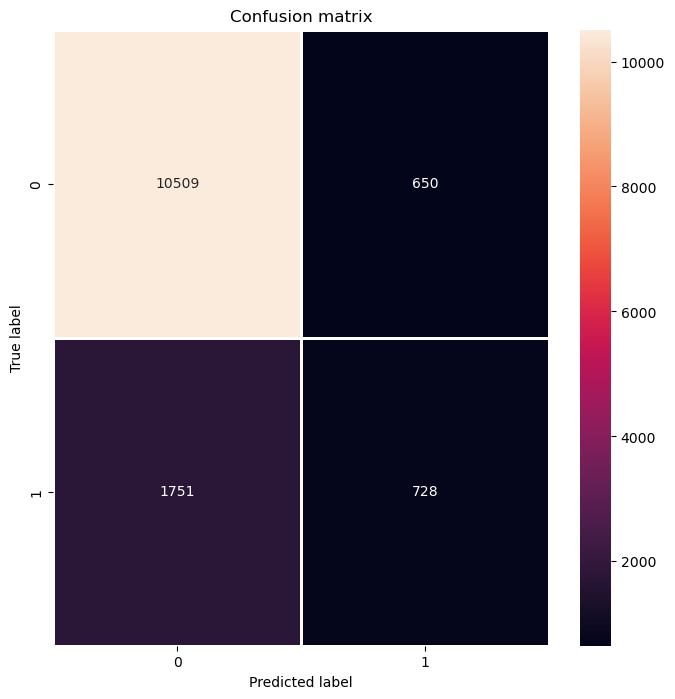



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.88     35538
         1.0       0.86      0.57      0.68     17769

    accuracy                           0.82     53307
   macro avg       0.84      0.76      0.78     53307
weighted avg       0.83      0.82      0.81     53307

ROC AUC: 0.8758772880856502
Accuracy: 0.8240943966083254


In [ ]:
print("Métricas SMOTE + RUS:")
train_and_test(ensamble, X_train_smote_rus, y_train_smote_rus, X_test, y_test)

### Modelo de Stacking con GXBoost, Random Forest y Catboost

En este método de ensamblado utilizamos las predicciones de los modelos de machine learning que queremos ensamblar como features para entrenar un nuevo modelo de machine learning.

Primero creamos los modelos de machine learning que queremos ensamblar

In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.02,
    max_depth=6,
    n_estimators=200,
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
)

clf = cb.CatBoostClassifier(
    depth = 6,
    iterations = 400,
    learning_rate = 0.05,
    random_seed=42
)

Luego, como tendremos que no solo entrenar a nuestros modelos, sino también a nuestro ensamble, dividimos el set de train en dos. 

In [ ]:
X_train_stack, X_val_stack, y_train_stack, y_val_stack = train_test_split(X_train_rus, y_train_rus, test_size=0.3, random_state=42)

Se probó usando SMOTE en estos nuevos sets, pero dio peores resultados

Luego entrenamos los modelos sobre el set de train para que nuestros modelos sean capaces de hacer predicciones

In [ ]:
rf.fit(X_train_stack, y_train_stack)
xgb.fit(X_train_stack, y_train_stack)
clf.fit(X_train_stack, y_train_stack)

0:	learn: 0.6810426	total: 5.66ms	remaining: 2.26s
1:	learn: 0.6697110	total: 11.2ms	remaining: 2.24s
2:	learn: 0.6594558	total: 16.7ms	remaining: 2.22s
3:	learn: 0.6502236	total: 22.1ms	remaining: 2.19s
4:	learn: 0.6418082	total: 27.5ms	remaining: 2.17s
5:	learn: 0.6340888	total: 32.9ms	remaining: 2.16s
6:	learn: 0.6267882	total: 38.4ms	remaining: 2.16s
7:	learn: 0.6207898	total: 43.8ms	remaining: 2.15s
8:	learn: 0.6152794	total: 49.3ms	remaining: 2.14s
9:	learn: 0.6103441	total: 54.8ms	remaining: 2.14s
10:	learn: 0.6059328	total: 60.5ms	remaining: 2.14s
11:	learn: 0.6017309	total: 66.1ms	remaining: 2.14s
12:	learn: 0.5977792	total: 71.5ms	remaining: 2.13s
13:	learn: 0.5943994	total: 77ms	remaining: 2.12s
14:	learn: 0.5908837	total: 82.4ms	remaining: 2.12s
15:	learn: 0.5881738	total: 87.7ms	remaining: 2.1s
16:	learn: 0.5853545	total: 93.1ms	remaining: 2.1s
17:	learn: 0.5829593	total: 98.5ms	remaining: 2.09s
18:	learn: 0.5803190	total: 104ms	remaining: 2.08s
19:	learn: 0.5779284	total:

Luego hacemos predicciones sobre el set de validación para usarlas como train en nuestro ensamble

In [ ]:
rf_preds = rf.predict_proba(X_val_stack)[:, 1]
xgb_preds = xgb.predict_proba(X_val_stack)[:, 1]
clf_preds = clf.predict_proba(X_val_stack)[:, 1]

In [ ]:
stack_features_training = np.column_stack((rf_preds, xgb_preds, clf_preds))

También hacemos que nuestros modelos predigan el set de test para usar estos datos a la hora de testear nuestro modelo de ensamble

In [ ]:
rf_preds_test = rf.predict_proba(X_test)[:, 1]
xgb_preds_test = xgb.predict_proba(X_test)[:, 1]
clf_preds_test = clf.predict_proba(X_test)[:, 1]
stack_features_testing = np.column_stack((rf_preds_test, xgb_preds_test, clf_preds_test))

Entrenamos nuestro modelo, el cual al solo tener tres features, elegimos que sea una regresión logística

In [ ]:
meta_model = LogisticRegression(max_iter=1000, random_state=42)

Métricas con el set de test
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88     11159
         1.0       0.47      0.43      0.45      2479

    accuracy                           0.81     13638
   macro avg       0.67      0.66      0.67     13638
weighted avg       0.80      0.81      0.81     13638

ROC AUC: 0.7600915166563937
Accuracy: 0.8095028596568412


Confusion matrix for the test predictions


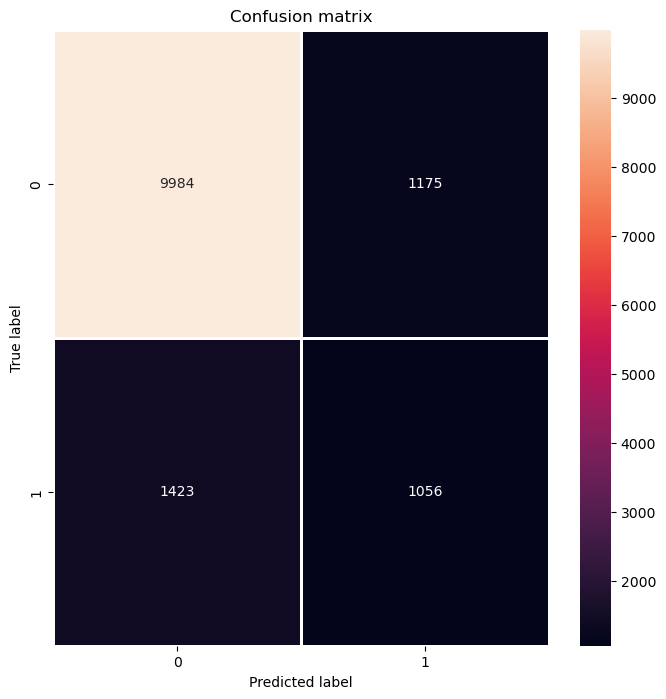



Métricas con el set de train
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      6087
         1.0       0.66      0.40      0.50      3026

    accuracy                           0.73      9113
   macro avg       0.71      0.65      0.66      9113
weighted avg       0.72      0.73      0.71      9113

ROC AUC: 0.7558474926954185
Accuracy: 0.7324700976626797


In [ ]:
train_and_test(meta_model, stack_features_training, y_val_stack, stack_features_testing, y_test)